# Libraries

In [1]:
import json
import pandas as pd
import sys
sys.path.insert(1, "./src")
sys.path.insert(1, "./src/enrich")
import download_youtube_infos
import numpy as np
import person_metadata
import time
import requests
from tqdm import tqdm
import urllib

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hechm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load db

In [2]:
db_path = "../dataset/yt_metadata.json"
videos_infos = download_youtube_infos.get_videos(db_path)
df = pd.DataFrame.from_records(videos_infos)
df.head(10)

,video_id,title,publishing_date,description,person,year_in_title
0,SRtnMcmt8-E,Gemma Arterton & Dominic Cooper chat to us abo...,2010-09-09T13:40:40Z,Subscribe to our channel: http://bit.ly/Empire...,"[Gemma Arterton, Dominic Cooper, Tamara Drewe]",
1,WUgz60174jo,"Ian Somerhalder Wants In On ""50 Shades"" Film |...",2012-04-23T14:59:21Z,"""SUBSCRIBE: http://full.sc/UBDdWt Would """"Vamp...","[Ian Somerhalder, Ryan Seacrest]",
2,li4SFwdLUos,Callan McAuliffe 'Disney's Prom' Premiere Inte...,2011-04-23T00:50:59Z,http://Facebook.com/ClevverTV - Become a Fan! ...,[Callan McAuliffe],
3,GUKVh9OpxJc,"Ian Somerhalder Interview ""The Vampire Diaries...",2016-07-24T00:20:01Z,Thank you to T-Mobile for sponsoring this epis...,[Ian Somerhalder],2016
4,wKozbkkc8UA,Sarah Wayne Callies Interview - The Walking De...,2013-07-09T14:10:02Z,Sarah Wayne Callies Interview - The Walking De...,"[Sarah Wayne, Wayne Callies]",
5,nzjbgrL_LYg,"Jake Johnson Teases Major Shake-Ups on ""New Gi...",2017-01-17T17:52:55Z,The actor dishes on Megan Fox's hilarious retu...,[Jake Johnson],
6,hk3bbAyHZ0o,Dan Aykroyd Interview,2009-06-16T20:58:44Z,An interview with Dan Akroyd on the Hill-Man M...,"[Dan Aykroyd, Aykroyd Interview]",
7,gjFhr6ECQzk,Ideas at the House: Tavi Gevinson - Why Being ...,2013-09-10T03:57:29Z,In this highlight from her talk at Sydney Oper...,[],
8,f1dpDmRDjDA,"Vanessa on ""Lifetime Intimate Portrait"", Octob...",2011-05-15T15:48:58Z,Vanessa talks to Lifetime Intimate Portrait ci...,[],2003
9,h4WdYGZkxwo,Om Puri in Aap Ki Adalat (Part 1),2013-05-13T11:18:42Z,Watch Bollywood actor Om Puri in Aap Ki Adalat...,[Om Puri],


In [3]:
df.shape

(170678, 6)

In [4]:
df.shape[0] - sum(df.publishing_date == "")

151091

In [5]:
sum(df.title == "")

19587

## Load Voxceleb metadata:

In [6]:
voxceleb_fn=["../dataset/vox2_meta.csv",
             "../dataset/vox1_meta.csv"]
sep = ["\s\t", "\t"]
li = []

for i, filename in enumerate(voxceleb_fn):
    temp_df = pd.read_csv(filename, sep=sep[i], encoding='utf-8')
    temp_df.columns = [x.replace("VGGFace1 ID", "Name") for x in temp_df.columns]
    print(temp_df.head())
    li.append(temp_df)

df_celeb = pd.concat(li, axis=0, ignore_index=True)
df_celeb.head()

               Name VoxCeleb2 ID VGGFace2 ID Gender   Set
0     Aaron_Ashmore      id00012     n000012      m   dev
1  Aaron_Motsoaledi      id00015     n000015      m   dev
2      Aaron_Ramsey      id00016     n000016      m   dev
3     Aaron_Rodgers      id00017     n000017      m  test
4      Aaron_Schock      id00018     n000018      m   dev
  VoxCeleb1 ID          Name Gender Nationality  Set
0      id10001  A.J._Buckley      m     Ireland  dev
1      id10002   A.R._Rahman      m       India  dev
2      id10003    Aamir_Khan      m       India  dev
3      id10004   Aaron_Tveit      m         USA  dev
4      id10005     Aaron_Yoo      m         USA  dev


C:\Users\hechm\miniconda3\envs\enrich_yt_videos\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,Name,VoxCeleb2 ID,VGGFace2 ID,Gender,Set,VoxCeleb1 ID,Nationality
0,Aaron_Ashmore,id00012,n000012,m,dev,NaN,NaN
1,Aaron_Motsoaledi,id00015,n000015,m,dev,NaN,NaN
2,Aaron_Ramsey,id00016,n000016,m,dev,NaN,NaN
3,Aaron_Rodgers,id00017,n000017,m,test,NaN,NaN
4,Aaron_Schock,id00018,n000018,m,dev,NaN,NaN


In [7]:
df_celeb['Name'] = df_celeb['Name'].str.replace("_", " ")

Do VoxCeleb1 and VoxCeleb 2 share anyID?

In [8]:
df_celeb.columns

Index(['Name', 'VoxCeleb2 ID', 'VGGFace2 ID', 'Gender', 'Set', 'VoxCeleb1 ID',
       'Nationality'],
      dtype='object')

In [9]:
set(df_celeb['VoxCeleb2 ID']).intersection(set(df_celeb['VoxCeleb1 ID']))

{nan}

Therefore, just for convenience, let's create one column where all IDS will be put, so that it will be easier to use them during the various joins.

In [10]:
vox_ids = []
for i in range(df_celeb.shape[0]):
    if df_celeb.iloc[i,:]['VoxCeleb2 ID'] != np.nan:
        vox_ids.append(df_celeb.iloc[i,:]['VoxCeleb2 ID'])
    else:
        vox_ids.append(df_celeb.iloc[i,:]['VoxCeleb1 ID'])
df_celeb['VoxCeleb_ID'] = vox_ids
df_celeb = df_celeb[['Name', 'VoxCeleb_ID']]

## Load YT IDs - Celebs mappings
The VoxCeleb dataset has two folder levels (Celebrities IDs - YT videos ID in which they compare

In [12]:
fn_person_videos = ['../dataset/voxceleb2_person_videos.json', '../dataset/voxceleb_person_videos.json']
person_videos = {}
for fn in fn_person_videos:
    with open(fn, 'r') as f:
        content = json.load(f)
        person_videos.update(content)

In [13]:
len(person_videos)

7363

In [14]:
fn_video_people = ['../dataset/voxceleb2_video_people.json', '../dataset/voxceleb_video_people.json']
video_people = {}
for fn in fn_video_people:
    with open(fn, 'r') as f:
        content = json.load(f)
        video_people.update(content)

In [15]:
len(video_people)

170678

## Download metadata

Let's now extract the list of unique names, that will be used for getting the various metadata from the API of interests

In [16]:
unique_vips = df_celeb['Name'].unique()
print(unique_vips)
len(unique_vips)

['Aaron_Ashmore' 'Aaron_Motsoaledi' 'Aaron_Ramsey' ... 'Zack_Snyder'
 'Zoe_Saldana' 'Zulay_Henao']


7365

I will now create the function that will query DBPedia and Wikidata endpoints. We will keep track of the VIPS we weren't able to download as well

In [17]:
def download_vips_metadata(unique_vips, endpoint):
    vips_metadata = []
    not_found_vips = []
    empty_data = 0
    for vip in tqdm(unique_vips):
        try:
            metadata = person_metadata.get_person_metadata(vip, endpoint)
            if metadata:
                vips_metadata.append(metadata)
            else:
                not_found_vips.append(vip)
        except Exception as ex:
            print("Couldn't download data for {}".format(vip))
            print(ex)
            not_found_vips.append(vip)
    return vips_metadata, not_found_vips

In [18]:
vips_metadata_wikidata, not_found_vips_wikidata = download_vips_metadata(unique_vips, 'wikidata')

  1%|▍                                                                             | 37/7365 [01:14<4:11:28,  2.06s/it]

Birth date not available


  1%|▌                                                                             | 55/7365 [01:50<4:12:58,  2.08s/it]

Birth date not available


  1%|▉                                                                             | 88/7365 [02:55<3:14:28,  1.60s/it]

Birth date not available
Gender not available
Citizenship not available


  2%|█▏                                                                           | 116/7365 [03:51<2:57:18,  1.47s/it]

Could not get metadata for Alana Curry: is the person's name spelled correctly?


  2%|█▏                                                                           | 119/7365 [03:56<2:57:09,  1.47s/it]

Citizenship not available


  2%|█▌                                                                           | 147/7365 [04:48<2:50:50,  1.42s/it]

Could not get metadata for Alex Aniston: is the person's name spelled correctly?


  2%|█▋                                                                           | 156/7365 [05:05<3:08:04,  1.57s/it]

Could not get metadata for Alex OLoughlin: is the person's name spelled correctly?


  2%|█▊                                                                           | 174/7365 [05:40<3:11:33,  1.60s/it]

Could not get metadata for Alexandra Lara: is the person's name spelled correctly?


  3%|█▉                                                                           | 191/7365 [06:12<2:57:15,  1.48s/it]

Birth date not available
Citizenship not available


  3%|██▏                                                                          | 204/7365 [06:35<2:58:43,  1.50s/it]

Birth date not available
Citizenship not available


  5%|████                                                                         | 384/7365 [12:37<3:06:12,  1.60s/it]

Citizenship not available


  5%|████                                                                         | 387/7365 [12:42<2:35:59,  1.34s/it]

Could not get metadata for Angela Simmons: is the person's name spelled correctly?


  6%|████▋                                                                        | 443/7365 [14:33<2:55:03,  1.52s/it]

Citizenship not available


  8%|██████▎                                                                      | 605/7365 [20:00<2:49:37,  1.51s/it]

Could not get metadata for Barbara dUrso: is the person's name spelled correctly?


  9%|███████▏                                                                     | 692/7365 [22:57<2:56:45,  1.59s/it]

Could not get metadata for Bhairvi Goswami: is the person's name spelled correctly?


 10%|███████▍                                                                     | 709/7365 [23:32<2:44:48,  1.49s/it]

Could not get metadata for Bill Gilman: is the person's name spelled correctly?


 13%|█████████▊                                                                   | 935/7365 [31:20<3:16:22,  1.83s/it]

Citizenship not available


 14%|██████████▎                                                                 | 1001/7365 [33:29<2:45:08,  1.56s/it]

Could not get metadata for Carrie Fletcher: is the person's name spelled correctly?


 14%|██████████▍                                                                 | 1012/7365 [33:54<3:41:17,  2.09s/it]

Gender not available


 14%|██████████▌                                                                 | 1019/7365 [34:05<2:43:50,  1.55s/it]

Birth date not available
Citizenship not available


 14%|██████████▌                                                                 | 1020/7365 [34:06<2:03:43,  1.17s/it]

Could not get metadata for Catherine OHara: is the person's name spelled correctly?


 15%|███████████▎                                                                | 1098/7365 [36:44<3:14:34,  1.86s/it]

Birth date not available
Citizenship not available


 16%|████████████                                                                | 1175/7365 [39:20<2:51:53,  1.67s/it]

Birth date not available
Citizenship not available


 16%|████████████▏                                                               | 1185/7365 [39:40<3:01:31,  1.76s/it]

Birth date not available
Gender not available
Citizenship not available


 17%|█████████████                                                               | 1261/7365 [42:16<2:17:32,  1.35s/it]

Birth date not available
Gender not available
Citizenship not available


 19%|██████████████▎                                                             | 1381/7365 [46:16<2:57:57,  1.78s/it]

Citizenship not available


 19%|██████████████▌                                                             | 1406/7365 [47:06<2:54:39,  1.76s/it]

Birth date not available
Gender not available
Citizenship not available


 20%|██████████████▉                                                             | 1445/7365 [48:25<2:31:54,  1.54s/it]

Could not get metadata for Dbanj: is the person's name spelled correctly?


 20%|███████████████▍                                                            | 1493/7365 [50:05<2:42:49,  1.66s/it]

Gender not available
Citizenship not available


 20%|███████████████▌                                                            | 1505/7365 [50:34<3:04:55,  1.89s/it]

Birth date not available
Gender not available
Citizenship not available


 21%|███████████████▉                                                            | 1547/7365 [52:05<2:49:37,  1.75s/it]

Birth date not available
Gender not available
Citizenship not available


 22%|████████████████▍                                                           | 1596/7365 [53:43<2:31:06,  1.57s/it]

Citizenship not available


 22%|████████████████▍                                                           | 1598/7365 [53:45<2:16:18,  1.42s/it]

Birth date not available
Gender not available
Citizenship not available


 22%|████████████████▋                                                           | 1616/7365 [54:20<2:37:43,  1.65s/it]

Citizenship not available


 23%|█████████████████▎                                                          | 1681/7365 [56:29<2:41:09,  1.70s/it]

Birth date not available
Citizenship not available


 23%|█████████████████▍                                                          | 1685/7365 [56:36<2:27:19,  1.56s/it]

Birth date not available
Gender not available
Citizenship not available


 23%|█████████████████▍                                                          | 1689/7365 [56:44<2:41:41,  1.71s/it]

Birth date not available
Gender not available
Citizenship not available


 23%|█████████████████▌                                                          | 1696/7365 [56:57<3:11:21,  2.03s/it]

Gender not available


 25%|██████████████████▋                                                       | 1856/7365 [1:02:28<2:43:16,  1.78s/it]

Birth date not available
Gender not available
Citizenship not available


 25%|██████████████████▊                                                       | 1869/7365 [1:02:53<2:40:32,  1.75s/it]

Citizenship not available


 26%|███████████████████                                                       | 1901/7365 [1:03:55<2:19:02,  1.53s/it]

Birth date not available
Citizenship not available


 26%|███████████████████▎                                                      | 1923/7365 [1:04:39<2:17:14,  1.51s/it]

Citizenship not available


 27%|███████████████████▊                                                      | 1972/7365 [1:06:16<2:16:59,  1.52s/it]

Birth date not available
Gender not available
Citizenship not available


 27%|████████████████████                                                      | 1995/7365 [1:06:59<2:09:18,  1.44s/it]

Could not get metadata for Genelia DSouza: is the person's name spelled correctly?


 28%|████████████████████▊                                                     | 2070/7365 [1:09:26<2:28:37,  1.68s/it]

Citizenship not available


 28%|████████████████████▉                                                     | 2082/7365 [1:09:48<2:10:36,  1.48s/it]

Citizenship not available


 29%|█████████████████████▊                                                    | 2172/7365 [1:12:50<1:59:32,  1.38s/it]

Could not get metadata for Hanna Beth: is the person's name spelled correctly?


 30%|██████████████████████                                                    | 2200/7365 [1:13:42<2:16:35,  1.59s/it]

Birth date not available
Gender not available
Citizenship not available


 30%|██████████████████████▌                                                   | 2241/7365 [1:15:05<2:43:09,  1.91s/it]

Birth date not available


 31%|██████████████████████▉                                                   | 2288/7365 [1:16:38<2:05:09,  1.48s/it]

Could not get metadata for Humaima Malik: is the person's name spelled correctly?


 32%|███████████████████████▊                                                  | 2369/7365 [1:19:15<2:24:55,  1.74s/it]

Citizenship not available


 32%|███████████████████████▊                                                  | 2373/7365 [1:19:21<2:14:39,  1.62s/it]

Citizenship not available


 32%|███████████████████████▉                                                  | 2384/7365 [1:19:43<2:19:44,  1.68s/it]

Birth date not available
Citizenship not available


 33%|████████████████████████                                                  | 2399/7365 [1:20:12<2:14:26,  1.62s/it]

Citizenship not available


 33%|████████████████████████▌                                                 | 2450/7365 [1:21:57<2:15:43,  1.66s/it]

Birth date not available
Citizenship not available


 33%|████████████████████████▋                                                 | 2459/7365 [1:22:14<2:12:39,  1.62s/it]

Citizenship not available


 34%|████████████████████████▉                                                 | 2477/7365 [1:22:48<2:06:21,  1.55s/it]

Birth date not available
Citizenship not available


 35%|█████████████████████████▌                                                | 2541/7365 [1:24:56<2:01:49,  1.52s/it]

Could not get metadata for Jason Wahler: is the person's name spelled correctly?


 35%|█████████████████████████▌                                                | 2544/7365 [1:25:00<1:54:52,  1.43s/it]

Birth date not available
Gender not available
Citizenship not available


 35%|█████████████████████████▋                                                | 2562/7365 [1:25:36<2:11:39,  1.64s/it]

Citizenship not available


 35%|██████████████████████████▏                                               | 2609/7365 [1:27:13<2:11:56,  1.66s/it]

Citizenship not available


 36%|██████████████████████████▎                                               | 2619/7365 [1:27:32<2:12:25,  1.67s/it]

Birth date not available
Gender not available
Citizenship not available


 36%|██████████████████████████▎                                               | 2620/7365 [1:27:34<2:21:19,  1.79s/it]

Birth date not available


 36%|██████████████████████████▌                                               | 2649/7365 [1:28:31<1:52:00,  1.42s/it]

Could not get metadata for Jerry OConnell: is the person's name spelled correctly?


 36%|██████████████████████████▉                                               | 2686/7365 [1:29:45<1:53:25,  1.45s/it]

Birth date not available
Citizenship not available


 37%|███████████████████████████▎                                              | 2718/7365 [1:30:52<1:57:52,  1.52s/it]

Could not get metadata for Jin-hee Ji: is the person's name spelled correctly?


 37%|███████████████████████████▌                                              | 2746/7365 [1:31:47<2:00:26,  1.56s/it]

Could not get metadata for Jodi Lyn OKeefe: is the person's name spelled correctly?


 39%|████████████████████████████▋                                             | 2853/7365 [1:35:26<1:59:08,  1.58s/it]

Birth date not available
Citizenship not available


 39%|████████████████████████████▉                                             | 2880/7365 [1:36:16<1:50:01,  1.47s/it]

Citizenship not available


 40%|█████████████████████████████▉                                            | 2974/7365 [1:39:31<2:01:42,  1.66s/it]

Birth date not available
Gender not available
Citizenship not available


 41%|██████████████████████████████▋                                           | 3054/7365 [1:42:15<1:42:29,  1.43s/it]

Could not get metadata for Karen Fairchild: is the person's name spelled correctly?


 42%|██████████████████████████████▊                                           | 3072/7365 [1:42:48<2:02:41,  1.71s/it]

Birth date not available
Citizenship not available


 42%|███████████████████████████████                                           | 3088/7365 [1:43:19<1:46:31,  1.49s/it]

Could not get metadata for Kate OMara: is the person's name spelled correctly?


 42%|███████████████████████████████▎                                          | 3120/7365 [1:44:24<1:53:43,  1.61s/it]

Could not get metadata for Katon W. De Pena: is the person's name spelled correctly?


 44%|████████████████████████████████▎                                         | 3222/7365 [1:47:51<1:47:00,  1.55s/it]

Could not get metadata for Kipton Cronkite: is the person's name spelled correctly?


 44%|████████████████████████████████▌                                         | 3240/7365 [1:48:27<1:52:25,  1.64s/it]

Could not get metadata for Koel Mallick: is the person's name spelled correctly?


 44%|████████████████████████████████▉                                         | 3275/7365 [1:49:36<1:57:41,  1.73s/it]

Could not get metadata for Krystle Lina: is the person's name spelled correctly?


 46%|██████████████████████████████████▍                                       | 3422/7365 [1:54:39<1:50:12,  1.68s/it]

Citizenship not available


 47%|██████████████████████████████████▍                                       | 3425/7365 [1:54:45<1:55:33,  1.76s/it]

Citizenship not available


 47%|██████████████████████████████████▍                                       | 3429/7365 [1:54:51<1:37:32,  1.49s/it]

Could not get metadata for Liana Mendoza: is the person's name spelled correctly?


 47%|██████████████████████████████████▌                                       | 3434/7365 [1:55:00<1:35:21,  1.46s/it]

Birth date not available
Gender not available
Citizenship not available


 47%|███████████████████████████████████                                       | 3487/7365 [1:56:45<1:36:33,  1.49s/it]

Citizenship not available


 48%|███████████████████████████████████▏                                      | 3503/7365 [1:57:16<1:46:08,  1.65s/it]

Citizenship not available


 48%|███████████████████████████████████▋                                      | 3546/7365 [1:58:36<1:37:40,  1.53s/it]

Citizenship not available


 48%|███████████████████████████████████▊                                      | 3560/7365 [1:59:02<1:37:50,  1.54s/it]

Citizenship not available


 49%|███████████████████████████████████▉                                      | 3581/7365 [1:59:43<1:34:18,  1.50s/it]

Could not get metadata for MC Harvey: is the person's name spelled correctly?


 49%|████████████████████████████████████▏                                     | 3599/7365 [2:00:16<1:37:53,  1.56s/it]

Birth date not available
Gender not available
Citizenship not available


 49%|████████████████████████████████████▎                                     | 3608/7365 [2:00:31<1:23:23,  1.33s/it]

Could not get metadata for Mahleej Sarkari: is the person's name spelled correctly?


 49%|████████████████████████████████████▎                                     | 3614/7365 [2:00:42<1:33:19,  1.49s/it]

Citizenship not available


 49%|████████████████████████████████████▍                                     | 3630/7365 [2:01:13<1:38:56,  1.59s/it]

Could not get metadata for Manchu Lakshmi Prasanna: is the person's name spelled correctly?


 49%|████████████████████████████████████▍                                     | 3632/7365 [2:01:16<1:24:23,  1.36s/it]

Birth date not available
Gender not available
Citizenship not available


 50%|█████████████████████████████████████▏                                    | 3700/7365 [2:03:32<1:34:25,  1.55s/it]

Could not get metadata for Margaret Blanchard: is the person's name spelled correctly?


 51%|█████████████████████████████████████▌                                    | 3733/7365 [2:04:35<1:39:08,  1.64s/it]

Birth date not available
Gender not available
Citizenship not available


 51%|█████████████████████████████████████▉                                    | 3776/7365 [2:06:06<1:43:34,  1.73s/it]

Birth date not available
Gender not available
Citizenship not available


 52%|██████████████████████████████████████▏                                   | 3800/7365 [2:06:53<1:42:34,  1.73s/it]

Could not get metadata for Martin OMalley: is the person's name spelled correctly?


 52%|██████████████████████████████████████▊                                   | 3862/7365 [2:09:00<1:35:56,  1.64s/it]

Birth date not available
Citizenship not available


 53%|███████████████████████████████████████▎                                  | 3912/7365 [2:10:40<1:34:35,  1.64s/it]

Birth date not available
Gender not available
Citizenship not available


 54%|████████████████████████████████████████▏                                 | 3994/7365 [2:13:26<1:38:02,  1.74s/it]

Birth date not available
Gender not available
Citizenship not available


 56%|█████████████████████████████████████████▏                                | 4100/7365 [2:17:13<1:30:10,  1.66s/it]

Birth date not available
Gender not available
Citizenship not available


 56%|█████████████████████████████████████████▎                                | 4106/7365 [2:17:23<1:19:33,  1.46s/it]

Birth date not available
Gender not available
Citizenship not available


 56%|█████████████████████████████████████████▎                                | 4111/7365 [2:17:32<1:23:18,  1.54s/it]

Birth date not available
Citizenship not available


 56%|█████████████████████████████████████████▌                                | 4135/7365 [2:18:22<1:39:56,  1.86s/it]

Citizenship not available


 56%|█████████████████████████████████████████▋                                | 4145/7365 [2:18:40<1:26:21,  1.61s/it]

Citizenship not available


 57%|█████████████████████████████████████████▉                                | 4173/7365 [2:19:37<1:37:37,  1.84s/it]

Birth date not available
Gender not available
Citizenship not available


 57%|█████████████████████████████████████████▉                                | 4174/7365 [2:19:38<1:18:13,  1.47s/it]

Birth date not available
Gender not available
Citizenship not available


 57%|█████████████████████████████████████████▉                                | 4180/7365 [2:19:49<1:24:41,  1.60s/it]

Birth date not available
Gender not available
Citizenship not available


 57%|██████████████████████████████████████████▏                               | 4195/7365 [2:20:17<1:15:12,  1.42s/it]

Could not get metadata for Nancy DellOlio: is the person's name spelled correctly?


 57%|██████████████████████████████████████████▏                               | 4198/7365 [2:20:22<1:15:11,  1.42s/it]

Birth date not available
Citizenship not available


 57%|██████████████████████████████████████████▍                               | 4227/7365 [2:21:21<1:22:42,  1.58s/it]

Birth date not available
Gender not available
Citizenship not available


 58%|██████████████████████████████████████████▊                               | 4257/7365 [2:22:25<1:22:23,  1.59s/it]

Birth date not available
Gender not available
Citizenship not available


 58%|███████████████████████████████████████████                               | 4286/7365 [2:23:22<1:18:30,  1.53s/it]

Citizenship not available


 58%|███████████████████████████████████████████▏                              | 4300/7365 [2:23:48<1:22:08,  1.61s/it]

Birth date not available
Gender not available
Citizenship not available


 59%|███████████████████████████████████████████▍                              | 4327/7365 [2:24:44<1:20:33,  1.59s/it]

Could not get metadata for Nicoletta Mantovani: is the person's name spelled correctly?


 59%|███████████████████████████████████████████▊                              | 4355/7365 [2:25:38<1:14:54,  1.49s/it]

Could not get metadata for Nina Watson: is the person's name spelled correctly?


 59%|███████████████████████████████████████████▉                              | 4374/7365 [2:26:15<1:15:49,  1.52s/it]

Could not get metadata for Norah ODonnell: is the person's name spelled correctly?


 60%|████████████████████████████████████████████▊                             | 4454/7365 [2:28:57<1:17:57,  1.61s/it]

Citizenship not available


 61%|████████████████████████████████████████████▉                             | 4474/7365 [2:29:37<1:23:31,  1.73s/it]

Birth date not available
Gender not available
Citizenship not available


 61%|█████████████████████████████████████████████▏                            | 4493/7365 [2:30:14<1:14:20,  1.55s/it]

Could not get metadata for Paul DiGiovanni: is the person's name spelled correctly?


 61%|█████████████████████████████████████████████▍                            | 4527/7365 [2:31:22<1:10:19,  1.49s/it]

Birth date not available
Gender not available
Citizenship not available


 62%|█████████████████████████████████████████████▋                            | 4548/7365 [2:32:02<1:13:39,  1.57s/it]

Birth date not available
Citizenship not available


 63%|██████████████████████████████████████████████▍                           | 4617/7365 [2:34:25<1:24:54,  1.85s/it]

Birth date not available


 63%|██████████████████████████████████████████████▋                           | 4651/7365 [2:36:39<2:34:18,  3.41s/it]

Could not get metadata for Prahladananda Swami: is the person's name spelled correctly?


 63%|██████████████████████████████████████████████▉                           | 4671/7365 [2:38:05<2:32:03,  3.39s/it]

Could not get metadata for Qorianka Kilcher: is the person's name spelled correctly?


 63%|██████████████████████████████████████████████▉                           | 4674/7365 [2:38:15<2:24:37,  3.22s/it]

Gender not available
Citizenship not available


 64%|███████████████████████████████████████████████                           | 4679/7365 [2:38:35<2:37:55,  3.53s/it]

Birth date not available
Gender not available
Citizenship not available


 64%|███████████████████████████████████████████████▎                          | 4711/7365 [2:40:23<1:15:22,  1.70s/it]

Birth date not available
Citizenship not available


 64%|███████████████████████████████████████████████▋                          | 4745/7365 [2:41:39<1:24:25,  1.93s/it]

Citizenship not available


 65%|███████████████████████████████████████████████▊                          | 4753/7365 [2:41:54<1:07:16,  1.55s/it]

Could not get metadata for Ramona Singer: is the person's name spelled correctly?


 65%|████████████████████████████████████████████████▎                         | 4803/7365 [2:43:36<1:04:05,  1.50s/it]

Could not get metadata for Remo DSouza: is the person's name spelled correctly?


 66%|████████████████████████████████████████████████▊                         | 4856/7365 [2:45:35<1:16:50,  1.84s/it]

Birth date not available
Gender not available
Citizenship not available


 68%|██████████████████████████████████████████████████                        | 4977/7365 [2:50:31<1:32:00,  2.31s/it]

Could not get metadata for Ronan OGara: is the person's name spelled correctly?


 68%|██████████████████████████████████████████████████▏                       | 4992/7365 [2:51:05<1:17:48,  1.97s/it]

Citizenship not available


 68%|██████████████████████████████████████████████████▏                       | 4998/7365 [2:51:19<1:34:57,  2.41s/it]

Gender not available


 68%|██████████████████████████████████████████████████▎                       | 5007/7365 [2:51:40<1:19:54,  2.03s/it]

Could not get metadata for Rosie ODonnell: is the person's name spelled correctly?


 69%|███████████████████████████████████████████████████▏                      | 5090/7365 [2:54:56<1:12:31,  1.91s/it]

Citizenship not available


 71%|█████████████████████████████████████████████████████▌                      | 5196/7365 [2:58:36<54:16,  1.50s/it]

Could not get metadata for Sean OPry: is the person's name spelled correctly?


 71%|█████████████████████████████████████████████████████▉                      | 5224/7365 [2:59:31<51:26,  1.44s/it]

Birth date not available
Gender not available
Citizenship not available


 72%|██████████████████████████████████████████████████████▍                     | 5272/7365 [3:01:04<54:20,  1.56s/it]

Citizenship not available


 72%|██████████████████████████████████████████████████████▋                     | 5298/7365 [3:01:57<58:01,  1.68s/it]

Citizenship not available


 73%|███████████████████████████████████████████████████████▎                    | 5358/7365 [3:03:56<57:23,  1.72s/it]

Citizenship not available


 73%|███████████████████████████████████████████████████████▎                    | 5360/7365 [3:03:59<47:34,  1.42s/it]

Birth date not available
Citizenship not available


 73%|███████████████████████████████████████████████████████▎                    | 5362/7365 [3:04:01<38:55,  1.17s/it]

Could not get metadata for Soledad OBrien: is the person's name spelled correctly?


 74%|████████████████████████████████████████████████████████▏                   | 5450/7365 [3:07:01<49:03,  1.54s/it]

Citizenship not available


 74%|████████████████████████████████████████████████████████▎                   | 5455/7365 [3:07:10<54:46,  1.72s/it]

Citizenship not available


 74%|████████████████████████████████████████████████████████▎                   | 5460/7365 [3:07:20<55:14,  1.74s/it]

Citizenship not available


 75%|████████████████████████████████████████████████████████▊                   | 5506/7365 [3:08:52<46:15,  1.49s/it]

Could not get metadata for Swathi Reddy: is the person's name spelled correctly?


 75%|█████████████████████████████████████████████████████████▏                  | 5541/7365 [3:10:01<44:49,  1.47s/it]

Could not get metadata for Tanaz Tabatabaei: is the person's name spelled correctly?


 77%|██████████████████████████████████████████████████████████▍                 | 5663/7365 [3:14:10<42:16,  1.49s/it]

Could not get metadata for Titus ONeil: is the person's name spelled correctly?


 77%|██████████████████████████████████████████████████████████▊                 | 5698/7365 [3:15:18<47:08,  1.70s/it]

Citizenship not available


 78%|███████████████████████████████████████████████████████████▍                | 5764/7365 [3:17:27<42:27,  1.59s/it]

Birth date not available
Gender not available
Citizenship not available


 79%|███████████████████████████████████████████████████████████▉                | 5806/7365 [3:18:55<44:08,  1.70s/it]

Birth date not available
Gender not available
Citizenship not available


 79%|████████████████████████████████████████████████████████████                | 5818/7365 [3:19:18<39:47,  1.54s/it]

Could not get metadata for V. K. Singh: is the person's name spelled correctly?


 79%|████████████████████████████████████████████████████████████▎               | 5844/7365 [3:20:08<40:01,  1.58s/it]

Birth date not available
Gender not available
Citizenship not available


 80%|████████████████████████████████████████████████████████████▉               | 5909/7365 [3:22:16<41:04,  1.69s/it]

Birth date not available
Gender not available
Citizenship not available


 81%|█████████████████████████████████████████████████████████████▍              | 5950/7365 [3:23:40<47:41,  2.02s/it]

Birth date not available


 81%|█████████████████████████████████████████████████████████████▊              | 5986/7365 [3:24:54<37:10,  1.62s/it]

Citizenship not available


 85%|████████████████████████████████████████████████████████████████▌           | 6262/7365 [3:34:22<30:25,  1.66s/it]

Birth date not available
Gender not available
Citizenship not available


 87%|█████████████████████████████████████████████████████████████████▉          | 6386/7365 [3:38:56<34:13,  2.10s/it]

Gender not available


 87%|██████████████████████████████████████████████████████████████████▎         | 6422/7365 [3:40:23<31:47,  2.02s/it]

Gender not available


 87%|██████████████████████████████████████████████████████████████████▎         | 6426/7365 [3:40:32<30:13,  1.93s/it]

Citizenship not available


 91%|█████████████████████████████████████████████████████████████████████▍      | 6726/7365 [3:51:18<16:21,  1.54s/it]

Could not get metadata for Katie Cleary: is the person's name spelled correctly?


 94%|███████████████████████████████████████████████████████████████████████▌    | 6938/7365 [3:58:49<15:37,  2.20s/it]

Gender not available


 94%|███████████████████████████████████████████████████████████████████████▋    | 6942/7365 [3:58:58<14:51,  2.11s/it]

Citizenship not available


 95%|███████████████████████████████████████████████████████████████████████▊    | 6961/7365 [3:59:37<12:21,  1.83s/it]

Birth date not available
Gender not available
Citizenship not available


 95%|████████████████████████████████████████████████████████████████████████▏   | 6999/7365 [4:00:59<10:41,  1.75s/it]

Birth date not available
Citizenship not available


 95%|████████████████████████████████████████████████████████████████████████▌   | 7029/7365 [4:02:08<10:27,  1.87s/it]

Birth date not available
Citizenship not available


 96%|████████████████████████████████████████████████████████████████████████▋   | 7039/7365 [4:02:30<10:37,  1.96s/it]

Citizenship not available


 96%|████████████████████████████████████████████████████████████████████████▊   | 7058/7365 [4:03:11<09:21,  1.83s/it]

Birth date not available
Gender not available
Citizenship not available


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7155/7365 [4:06:48<09:06,  2.60s/it]

Gender not available


100%|████████████████████████████████████████████████████████████████████████████| 7365/7365 [4:16:00<00:00,  2.09s/it]


In [19]:
len(vips_metadata_wikidata)

7317

In [20]:
vips_metadata_wikidata_df = pd.DataFrame.from_records(vips_metadata_wikidata)
vips_metadata_wikidata_df.head()

,gender,birth_date,nationality,name
0,male,+1979-10-07T00:00:00Z,Canada,Aaron Ashmore
1,male,+1958-08-07T00:00:00Z,South-Africa,Aaron Motsoaledi
2,male,+1990-12-26T00:00:00Z,The-United-Kingdom-1,Aaron Ramsey
3,male,+1983-12-02T00:00:00Z,The-United-States-of-America,Aaron Rodgers
4,male,+1981-05-28T00:00:00Z,The-United-States-of-America,Aaron Schock


Let's now remove, from birth date the plus sign, as well as the hour:min:sec values

In [21]:
vips_metadata_wikidata_df.birth_date = vips_metadata_wikidata_df.birth_date.str.slice(1,11)
vips_metadata_wikidata_df.head()

,gender,birth_date,nationality,name
0,male,1979-10-07,Canada,Aaron Ashmore
1,male,1958-08-07,South-Africa,Aaron Motsoaledi
2,male,1990-12-26,The-United-Kingdom-1,Aaron Ramsey
3,male,1983-12-02,The-United-States-of-America,Aaron Rodgers
4,male,1981-05-28,The-United-States-of-America,Aaron Schock


For avoiding to redo the API query I will export the df in a proper CSV

In [22]:
vips_metadata_wikidata_df.to_csv("vips_metadata_wikidata_fixed.csv", index=False)
Uncomment this instruction for avoiding to redo the download
#vips_metadata_wikidata_df = pd.read_csv("vips_metadata_wikidata_fixed.csv")

In [25]:
with open("../dataset/not_found_vips_wikidata.json", "w") as f:
    f.write(json.dumps(not_found_vips_wikidata))
not_found_vips_wikidata


['Alana Curry',
 'Alex Aniston',
 'Alex OLoughlin',
 'Alexandra Lara',
 'Angela Simmons',
 'Barbara dUrso',
 'Bhairvi Goswami',
 'Bill Gilman',
 'Carrie Fletcher',
 'Catherine OHara',
 'Dbanj',
 'Genelia DSouza',
 'Hanna Beth',
 'Humaima Malik',
 'Jason Wahler',
 'Jerry OConnell',
 'Jin-hee Ji',
 'Jodi Lyn OKeefe',
 'Karen Fairchild',
 'Kate OMara',
 'Katon W. De Pena',
 'Kipton Cronkite',
 'Koel Mallick',
 'Krystle Lina',
 'Liana Mendoza',
 'MC Harvey',
 'Mahleej Sarkari',
 'Manchu Lakshmi Prasanna',
 'Margaret Blanchard',
 'Martin OMalley',
 'Nancy DellOlio',
 'Nicoletta Mantovani',
 'Nina Watson',
 'Norah ODonnell',
 'Paul DiGiovanni',
 'Prahladananda Swami',
 'Qorianka Kilcher',
 'Ramona Singer',
 'Remo DSouza',
 'Ronan OGara',
 'Rosie ODonnell',
 'Sean OPry',
 'Soledad OBrien',
 'Swathi Reddy',
 'Tanaz Tabatabaei',
 'Titus ONeil',
 'V. K. Singh',
 'Katie Cleary']

### DBPedia

In [26]:
vips_metadata_dbpedia, not_found_vips_dbpedia = download_vips_metadata(unique_vips, 'dbpedia')

  1%|▌                                                                               | 50/7365 [00:07<15:00,  8.12it/s]

Could not get metadata for Aderbal Freire Filho: is the person's name spelled correctly?


  1%|▉                                                                               | 89/7365 [00:12<15:29,  7.83it/s]

Could not get metadata for Aishwarya Rai Bachchan: is the person's name spelled correctly?


  1%|█                                                                               | 99/7365 [00:13<15:56,  7.60it/s]

Could not get metadata for Al Bano Carrisi: is the person's name spelled correctly?


  2%|█▎                                                                             | 117/7365 [00:16<14:28,  8.35it/s]

Could not get metadata for Alana Curry: is the person's name spelled correctly?


  2%|█▌                                                                             | 148/7365 [00:20<13:55,  8.64it/s]

Could not get metadata for Alex Aniston: is the person's name spelled correctly?


  2%|█▋                                                                             | 157/7365 [00:21<13:41,  8.77it/s]

Could not get metadata for Alex OLoughlin: is the person's name spelled correctly?


  2%|█▉                                                                             | 175/7365 [00:24<16:57,  7.06it/s]

Could not get metadata for Alexandra Lara: is the person's name spelled correctly?


  3%|██▏                                                                            | 202/7365 [00:33<19:52,  6.01it/s]

Could not get metadata for Ali al-Naimi: is the person's name spelled correctly?


  3%|██▋                                                                            | 252/7365 [00:39<14:31,  8.16it/s]

Could not get metadata for Amare Stoudemire: is the person's name spelled correctly?


  4%|██▉                                                                            | 276/7365 [00:42<14:23,  8.21it/s]

Could not get metadata for Amy Dumas: is the person's name spelled correctly?


  4%|███▏                                                                           | 294/7365 [00:44<13:27,  8.75it/s]

Could not get metadata for Ana Patricia Botin: is the person's name spelled correctly?


  4%|███▏                                                                           | 297/7365 [00:44<13:41,  8.61it/s]

Could not get metadata for Anahí de Cardenas: is the person's name spelled correctly?


  4%|███▍                                                                           | 321/7365 [00:48<13:29,  8.70it/s]

Could not get metadata for Andrea Kaiser: is the person's name spelled correctly?


  5%|███▌                                                                           | 332/7365 [00:49<13:17,  8.81it/s]

Could not get metadata for Andrea Veresova: is the person's name spelled correctly?


  5%|███▋                                                                           | 338/7365 [00:50<14:23,  8.13it/s]

Could not get metadata for Andreas Jancke: is the person's name spelled correctly?


  5%|████▏                                                                          | 388/7365 [00:56<17:39,  6.59it/s]

Could not get metadata for Angela Simmons: is the person's name spelled correctly?


  5%|████▏                                                                          | 390/7365 [00:56<15:51,  7.33it/s]

Could not get metadata for Angelica Celaya: is the person's name spelled correctly?


  6%|████▌                                                                          | 430/7365 [01:05<13:22,  8.64it/s]

Could not get metadata for Annabelle Mandeng: is the person's name spelled correctly?


  6%|████▋                                                                          | 433/7365 [01:06<13:23,  8.63it/s]

Could not get metadata for Anne-Sophie Briest: is the person's name spelled correctly?


  6%|████▊                                                                          | 449/7365 [01:08<14:38,  7.87it/s]

Could not get metadata for Annemarie Warnkross: is the person's name spelled correctly?


  7%|█████▌                                                                         | 516/7365 [01:16<17:05,  6.68it/s]

Could not get metadata for Arié Elmaleh: is the person's name spelled correctly?


  7%|█████▋                                                                         | 526/7365 [01:17<13:45,  8.28it/s]

Could not get metadata for Arno Del Curto: is the person's name spelled correctly?


  7%|█████▊                                                                         | 540/7365 [01:19<14:26,  7.88it/s]

Could not get metadata for Arya Babbar: is the person's name spelled correctly?


  8%|██████▏                                                                        | 579/7365 [01:25<16:18,  6.93it/s]

Could not get metadata for Azadeh Samadi: is the person's name spelled correctly?


  8%|██████▏                                                                        | 581/7365 [01:27<38:37,  2.93it/s]

Could not get metadata for Azmin Ali: is the person's name spelled correctly?


  8%|██████                                                                       | 583/7365 [01:30<1:39:24,  1.14it/s]

Could not get metadata for B. J. Thomas: is the person's name spelled correctly?


  8%|██████                                                                       | 584/7365 [01:30<1:21:28,  1.39it/s]

Could not get metadata for B. J. Upton: is the person's name spelled correctly?


  8%|██████▍                                                                        | 604/7365 [01:34<14:08,  7.97it/s]

Could not get metadata for Barbara Schett: is the person's name spelled correctly?


  8%|██████▌                                                                        | 606/7365 [01:34<13:47,  8.17it/s]

Could not get metadata for Barbara dUrso: is the person's name spelled correctly?


  8%|██████▋                                                                        | 622/7365 [01:37<14:13,  7.90it/s]

Could not get metadata for Beate Merk: is the person's name spelled correctly?


  9%|███████▏                                                                       | 671/7365 [01:44<15:48,  7.06it/s]

Could not get metadata for Bertie Gilbert: is the person's name spelled correctly?


  9%|███████▎                                                                       | 682/7365 [01:46<19:30,  5.71it/s]

Could not get metadata for Beth Winslet: is the person's name spelled correctly?


  9%|███████▎                                                                       | 684/7365 [01:46<16:55,  6.58it/s]

Could not get metadata for Beto Cuevas: is the person's name spelled correctly?


  9%|███████▍                                                                       | 688/7365 [01:47<16:17,  6.83it/s]

Could not get metadata for Bettina Vollath: is the person's name spelled correctly?


  9%|███████▍                                                                       | 690/7365 [01:47<14:41,  7.57it/s]

Could not get metadata for Bettina Zimmermann: is the person's name spelled correctly?


  9%|███████▍                                                                       | 693/7365 [01:47<14:10,  7.84it/s]

Could not get metadata for Bhairvi Goswami: is the person's name spelled correctly?


  9%|███████▍                                                                       | 696/7365 [01:48<13:30,  8.23it/s]

Could not get metadata for Bhavana Menon: is the person's name spelled correctly?


 10%|███████▌                                                                       | 706/7365 [01:49<13:55,  7.97it/s]

Could not get metadata for Bilkay Öney: is the person's name spelled correctly?


 10%|███████▌                                                                       | 710/7365 [01:49<13:56,  7.95it/s]

Could not get metadata for Bill Gilman: is the person's name spelled correctly?


 12%|█████████▏                                                                     | 860/7365 [02:14<12:56,  8.37it/s]

Could not get metadata for Brodinski: is the person's name spelled correctly?


 12%|█████████▎                                                                     | 873/7365 [02:16<12:56,  8.36it/s]

Could not get metadata for Bruce Jenner: is the person's name spelled correctly?


 12%|█████████▍                                                                     | 881/7365 [02:17<13:03,  8.27it/s]

Could not get metadata for Bruno Madinier: is the person's name spelled correctly?


 12%|█████████▍                                                                     | 883/7365 [02:17<13:18,  8.12it/s]

Could not get metadata for Bruno Solo: is the person's name spelled correctly?


 12%|█████████▋                                                                     | 904/7365 [02:20<12:33,  8.57it/s]

Could not get metadata for C.C.Catch: is the person's name spelled correctly?


 12%|█████████▊                                                                     | 914/7365 [02:21<13:14,  8.12it/s]

Could not get metadata for Cameron Quiseng: is the person's name spelled correctly?


 13%|█████████▉                                                                     | 928/7365 [02:23<13:05,  8.20it/s]

Could not get metadata for Candace Cameron-Bure: is the person's name spelled correctly?


 13%|██████████▎                                                                    | 964/7365 [02:32<54:46,  1.95it/s]

Could not get metadata for Carlos Lupi: is the person's name spelled correctly?


 14%|██████████▌                                                                   | 1002/7365 [02:37<12:31,  8.47it/s]

Could not get metadata for Carrie Fletcher: is the person's name spelled correctly?


 14%|██████████▊                                                                   | 1020/7365 [02:39<11:56,  8.85it/s]

Could not get metadata for Catherine Jenkins: is the person's name spelled correctly?
Could not get metadata for Catherine OHara: is the person's name spelled correctly?


 14%|███████████                                                                   | 1049/7365 [02:43<28:48,  3.65it/s]

Could not get metadata for Chantal Poullain: is the person's name spelled correctly?


 15%|███████████▍                                                                  | 1082/7365 [02:48<13:11,  7.94it/s]

Could not get metadata for Charlotte Salt: is the person's name spelled correctly?


 15%|███████████▌                                                                  | 1090/7365 [02:49<12:40,  8.25it/s]

Could not get metadata for Cheryl Cole: is the person's name spelled correctly?


 16%|████████████▊                                                                 | 1210/7365 [03:07<12:12,  8.40it/s]

Could not get metadata for Claus Weselsky: is the person's name spelled correctly?


 16%|████████████▊                                                                 | 1214/7365 [03:08<13:50,  7.41it/s]

Could not get metadata for Clemens Schick: is the person's name spelled correctly?


 17%|████████████▉                                                                 | 1217/7365 [03:08<13:16,  7.72it/s]

Could not get metadata for Clifton Collins, Jr.: is the person's name spelled correctly?


 17%|█████████████                                                                 | 1237/7365 [03:10<11:38,  8.77it/s]

Could not get metadata for Cole Sprouse: is the person's name spelled correctly?


 17%|█████████████▏                                                                | 1243/7365 [03:11<11:59,  8.51it/s]

Could not get metadata for Colin Kaepernick: is the person's name spelled correctly?


 17%|█████████████▏                                                                | 1247/7365 [03:12<11:32,  8.83it/s]

Could not get metadata for Conan OBrien: is the person's name spelled correctly?


 17%|█████████████▌                                                                | 1278/7365 [03:15<11:59,  8.46it/s]

Could not get metadata for Cuba Gooding, Jr.: is the person's name spelled correctly?


 17%|█████████████▌                                                                | 1283/7365 [03:16<11:33,  8.77it/s]

Could not get metadata for Czeslaw Mozil: is the person's name spelled correctly?


 18%|█████████████▊                                                                | 1301/7365 [03:18<11:37,  8.69it/s]

Could not get metadata for Daisy De La Hoya: is the person's name spelled correctly?


 18%|█████████████▊                                                                | 1303/7365 [03:18<11:42,  8.63it/s]

Could not get metadata for Dale Earnhardt, Jr.: is the person's name spelled correctly?


 18%|██████████████▎                                                               | 1357/7365 [03:25<11:31,  8.69it/s]

Could not get metadata for Danneel Ackles: is the person's name spelled correctly?


 20%|███████████████▎                                                              | 1446/7365 [03:40<11:38,  8.48it/s]

Could not get metadata for Dbanj: is the person's name spelled correctly?


 20%|███████████████▉                                                              | 1505/7365 [03:47<13:14,  7.38it/s]

Could not get metadata for Devanny Pinn: is the person's name spelled correctly?


 21%|████████████████▏                                                             | 1530/7365 [03:50<11:30,  8.45it/s]

Could not get metadata for Diego Botto: is the person's name spelled correctly?


 21%|████████████████▎                                                             | 1539/7365 [03:51<10:59,  8.83it/s]

Could not get metadata for Dieter Thomas Kuhn: is the person's name spelled correctly?


 21%|████████████████▎                                                             | 1543/7365 [03:51<11:10,  8.68it/s]

Could not get metadata for Dietrich Brüggemann: is the person's name spelled correctly?


 21%|████████████████▌                                                             | 1562/7365 [03:54<12:45,  7.58it/s]

Could not get metadata for Divya Khosla: is the person's name spelled correctly?


 21%|████████████████▋                                                             | 1581/7365 [03:57<25:15,  3.82it/s]

Could not get metadata for Donald Trump, Jr.: is the person's name spelled correctly?


 22%|████████████████▉                                                             | 1599/7365 [04:04<11:42,  8.21it/s]

Could not get metadata for Dravid: is the person's name spelled correctly?


 22%|█████████████████▍                                                            | 1644/7365 [04:09<11:08,  8.55it/s]

Could not get metadata for Edinson Volquez: is the person's name spelled correctly?


 23%|█████████████████▉                                                            | 1690/7365 [04:15<10:54,  8.68it/s]

Could not get metadata for Elizabeth Shannon: is the person's name spelled correctly?


 23%|██████████████████▏                                                           | 1712/7365 [04:18<11:00,  8.56it/s]

Could not get metadata for Elyas M’Barek: is the person's name spelled correctly?


 23%|██████████████████▎                                                           | 1724/7365 [04:19<10:32,  8.92it/s]

Could not get metadata for Emma Marcegaglia: is the person's name spelled correctly?


 25%|███████████████████▏                                                          | 1806/7365 [04:35<11:04,  8.36it/s]

Could not get metadata for Eve Angeli: is the person's name spelled correctly?


 25%|███████████████████▏                                                          | 1811/7365 [04:36<10:55,  8.47it/s]

Could not get metadata for Evelyne Brochu: is the person's name spelled correctly?


 25%|███████████████████▎                                                          | 1826/7365 [04:37<10:42,  8.62it/s]

Could not get metadata for Fabio Troiano: is the person's name spelled correctly?


 25%|███████████████████▋                                                          | 1857/7365 [04:41<12:01,  7.64it/s]

Could not get metadata for Felipe Gonzales: is the person's name spelled correctly?


 26%|████████████████████                                                          | 1900/7365 [04:47<10:40,  8.53it/s]

Could not get metadata for Francesco Pannofino: is the person's name spelled correctly?


 26%|████████████████████▌                                                         | 1936/7365 [04:51<10:34,  8.56it/s]

Could not get metadata for Frederic Beigbeder: is the person's name spelled correctly?


 26%|████████████████████▌                                                         | 1941/7365 [04:52<11:15,  8.04it/s]

Could not get metadata for Fredy Bickel: is the person's name spelled correctly?


 27%|█████████████████████                                                         | 1992/7365 [05:02<13:26,  6.66it/s]

Could not get metadata for Geetha Madhuri: is the person's name spelled correctly?


 27%|█████████████████████▏                                                        | 1996/7365 [05:02<15:09,  5.90it/s]

Could not get metadata for Genelia DSouza: is the person's name spelled correctly?


 28%|█████████████████████▌                                                        | 2038/7365 [05:08<11:09,  7.96it/s]

Could not get metadata for Gigi Ravelli: is the person's name spelled correctly?


 28%|█████████████████████▊                                                        | 2059/7365 [05:11<10:58,  8.06it/s]

Could not get metadata for Giovane Élber: is the person's name spelled correctly?


 29%|██████████████████████▌                                                       | 2127/7365 [05:20<10:13,  8.53it/s]

Could not get metadata for Gurmeet Ram Rahim Singh: is the person's name spelled correctly?


 29%|██████████████████████▊                                                       | 2155/7365 [05:23<10:45,  8.08it/s]

Could not get metadata for H. P. Baxxter: is the person's name spelled correctly?


 29%|██████████████████████▊                                                       | 2157/7365 [05:23<11:27,  7.57it/s]

Could not get metadata for Hadewych Minis: is the person's name spelled correctly?


 29%|██████████████████████▉                                                       | 2168/7365 [05:25<10:35,  8.18it/s]

Could not get metadata for Hamsa Nandini: is the person's name spelled correctly?


 30%|███████████████████████                                                       | 2173/7365 [05:25<10:08,  8.54it/s]

Could not get metadata for Hanna Beth: is the person's name spelled correctly?


 30%|███████████████████████▎                                                      | 2201/7365 [05:34<16:15,  5.29it/s]

Could not get metadata for Harry Connick, Jr.: is the person's name spelled correctly?


 30%|███████████████████████▌                                                      | 2222/7365 [05:37<10:14,  8.37it/s]

Could not get metadata for Heather Elizabeth Morris: is the person's name spelled correctly?


 31%|████████████████████████                                                      | 2268/7365 [05:43<10:45,  7.90it/s]

Could not get metadata for Hilde Mattheis: is the person's name spelled correctly?
Could not get metadata for Hillary Rodham Clinton: is the person's name spelled correctly?


 31%|████████████████████████▏                                                     | 2289/7365 [05:45<12:06,  6.99it/s]

Could not get metadata for Humaima Malik: is the person's name spelled correctly?


 31%|████████████████████████▍                                                     | 2302/7365 [05:47<11:51,  7.12it/s]

Could not get metadata for Ian Hecox: is the person's name spelled correctly?


 32%|████████████████████████▋                                                     | 2329/7365 [05:52<10:20,  8.12it/s]

Could not get metadata for Indira Vladić: is the person's name spelled correctly?


 32%|████████████████████████▋                                                     | 2331/7365 [05:52<11:03,  7.59it/s]

Could not get metadata for Ines Sainz Gallo: is the person's name spelled correctly?


 32%|█████████████████████████                                                     | 2364/7365 [05:57<14:58,  5.56it/s]

Could not get metadata for Iva Pazderková: is the person's name spelled correctly?


 32%|█████████████████████████▏                                                    | 2379/7365 [06:03<12:51,  6.46it/s]

Could not get metadata for J.R. Martinez: is the person's name spelled correctly?


 32%|█████████████████████████▎                                                    | 2389/7365 [06:04<09:43,  8.53it/s]

Could not get metadata for Jacek Rostowski: is the person's name spelled correctly?


 33%|█████████████████████████▋                                                    | 2427/7365 [06:09<10:11,  8.07it/s]

Could not get metadata for Jaime Faith Edmondson: is the person's name spelled correctly?


 33%|█████████████████████████▊                                                    | 2440/7365 [06:10<09:45,  8.41it/s]

Could not get metadata for Jakub Smolík: is the person's name spelled correctly?


 33%|█████████████████████████▉                                                    | 2451/7365 [06:12<10:08,  8.08it/s]

Could not get metadata for James DArcy: is the person's name spelled correctly?


 33%|█████████████████████████▉                                                    | 2454/7365 [06:12<09:43,  8.42it/s]

Could not get metadata for James Dimon: is the person's name spelled correctly?


 33%|██████████████████████████▏                                                   | 2467/7365 [06:14<09:29,  8.60it/s]

Could not get metadata for James Pickens Jr.: is the person's name spelled correctly?


 34%|██████████████████████████▏                                                   | 2475/7365 [06:15<09:24,  8.66it/s]

Could not get metadata for Jamie Colby: is the person's name spelled correctly?


 34%|██████████████████████████▍                                                   | 2501/7365 [06:18<09:21,  8.67it/s]

Could not get metadata for Janelle Monae: is the person's name spelled correctly?


 34%|██████████████████████████▌                                                   | 2511/7365 [06:19<14:11,  5.70it/s]

Could not get metadata for Jared Followill: is the person's name spelled correctly?


 34%|██████████████████████████▋                                                   | 2518/7365 [06:20<10:21,  7.80it/s]

Could not get metadata for Jarmila Gajdošová: is the person's name spelled correctly?


 35%|██████████████████████████▉                                                   | 2542/7365 [06:23<09:41,  8.29it/s]

Could not get metadata for Jason Wahler: is the person's name spelled correctly?


 35%|██████████████████████████▉                                                   | 2546/7365 [06:24<09:15,  8.68it/s]

Could not get metadata for Jay-Z: is the person's name spelled correctly?


 36%|███████████████████████████▊                                                  | 2622/7365 [06:37<09:54,  7.97it/s]

Could not get metadata for Jennifer Gimenez: is the person's name spelled correctly?


 36%|███████████████████████████▊                                                  | 2631/7365 [06:38<09:02,  8.72it/s]

Could not get metadata for Jenny Elvers-Elbertzhagen: is the person's name spelled correctly?


 36%|████████████████████████████                                                  | 2650/7365 [06:40<08:53,  8.83it/s]

Could not get metadata for Jerry OConnell: is the person's name spelled correctly?


 37%|████████████████████████████▍                                                 | 2689/7365 [06:45<09:21,  8.32it/s]

Could not get metadata for Jette Joop: is the person's name spelled correctly?


 37%|████████████████████████████▌                                                 | 2694/7365 [06:45<09:03,  8.59it/s]

Could not get metadata for Jill Kargman: is the person's name spelled correctly?


 37%|████████████████████████████▊                                                 | 2719/7365 [06:48<09:02,  8.56it/s]

Could not get metadata for Jin-hee Ji: is the person's name spelled correctly?


 37%|█████████████████████████████                                                 | 2747/7365 [06:52<09:36,  8.02it/s]

Could not get metadata for Jodi Lyn OKeefe: is the person's name spelled correctly?


 38%|█████████████████████████████▎                                                | 2764/7365 [06:54<09:21,  8.20it/s]

Could not get metadata for Joel Coen: is the person's name spelled correctly?


 38%|█████████████████████████████▍                                                | 2783/7365 [07:01<43:01,  1.78it/s]

Could not get metadata for Johannes Remmel: is the person's name spelled correctly?


 38%|█████████████████████████████▋                                                | 2808/7365 [07:07<12:06,  6.27it/s]

Could not get metadata for John T. Chambers: is the person's name spelled correctly?


 39%|██████████████████████████████▏                                               | 2849/7365 [07:12<22:59,  3.27it/s]

Could not get metadata for Jonathan Meyers: is the person's name spelled correctly?


 39%|██████████████████████████████▋                                               | 2894/7365 [07:20<09:40,  7.71it/s]

Could not get metadata for Joshua Bowman: is the person's name spelled correctly?


 40%|███████████████████████████████▎                                              | 2960/7365 [07:34<09:33,  7.68it/s]

Could not get metadata for Juliano Cazarre: is the person's name spelled correctly?


 40%|███████████████████████████████▍                                              | 2967/7365 [07:35<08:46,  8.36it/s]

Could not get metadata for Julie Piétri: is the person's name spelled correctly?


 40%|███████████████████████████████▌                                              | 2975/7365 [07:36<08:21,  8.75it/s]

Could not get metadata for Julio César Chávez, Jr.: is the person's name spelled correctly?


 41%|███████████████████████████████▉                                              | 3014/7365 [07:41<08:12,  8.84it/s]

Could not get metadata for K-Maro: is the person's name spelled correctly?


 41%|███████████████████████████████▉                                              | 3020/7365 [07:42<11:22,  6.37it/s]

Could not get metadata for Kader Loth: is the person's name spelled correctly?


 41%|████████████████████████████████                                              | 3022/7365 [07:42<09:46,  7.40it/s]

Could not get metadata for Kai Schumann: is the person's name spelled correctly?


 41%|████████████████████████████████▎                                             | 3051/7365 [07:47<10:07,  7.10it/s]

Could not get metadata for Kareena Kapoor Khan: is the person's name spelled correctly?


 41%|████████████████████████████████▎                                             | 3055/7365 [07:47<09:00,  7.97it/s]

Could not get metadata for Karen Fairchild: is the person's name spelled correctly?


 42%|████████████████████████████████▍                                             | 3062/7365 [07:48<08:31,  8.41it/s]

Could not get metadata for Karin Ontiveros: is the person's name spelled correctly?


 42%|████████████████████████████████▋                                             | 3089/7365 [07:51<09:30,  7.50it/s]

Could not get metadata for Kate OMara: is the person's name spelled correctly?


 42%|█████████████████████████████████                                             | 3121/7365 [07:55<08:45,  8.07it/s]

Could not get metadata for Katon W. De Pena: is the person's name spelled correctly?


 44%|█████████████████████████████████▉                                            | 3209/7365 [08:10<08:37,  8.03it/s]

Could not get metadata for Kim Matula: is the person's name spelled correctly?


 44%|██████████████████████████████████▏                                           | 3223/7365 [08:12<08:21,  8.26it/s]

Could not get metadata for Kipton Cronkite: is the person's name spelled correctly?


 44%|██████████████████████████████████▍                                           | 3246/7365 [08:15<07:36,  9.03it/s]

Could not get metadata for Koo Ja-Cheol: is the person's name spelled correctly?


 44%|██████████████████████████████████▍                                           | 3253/7365 [08:15<07:47,  8.79it/s]

Could not get metadata for Kris Letang: is the person's name spelled correctly?


 44%|██████████████████████████████████▋                                           | 3276/7365 [08:18<07:55,  8.61it/s]

Could not get metadata for Krystle Lina: is the person's name spelled correctly?


 46%|███████████████████████████████████▌                                          | 3361/7365 [08:34<11:31,  5.79it/s]

Could not get metadata for Laurent Gerra: is the person's name spelled correctly?


 46%|███████████████████████████████████▋                                          | 3370/7365 [08:35<08:07,  8.20it/s]

Could not get metadata for Lazaro Hernandez: is the person's name spelled correctly?


 46%|████████████████████████████████████                                          | 3406/7365 [08:41<13:26,  4.91it/s]

Could not get metadata for Leonard Lansink: is the person's name spelled correctly?


 46%|████████████████████████████████████▏                                         | 3415/7365 [08:42<08:27,  7.79it/s]

Could not get metadata for Leslie Mandoki: is the person's name spelled correctly?


 46%|████████████████████████████████████▏                                         | 3419/7365 [08:43<11:10,  5.89it/s]

Could not get metadata for Leticia Van de Putte: is the person's name spelled correctly?


 47%|████████████████████████████████████▎                                         | 3430/7365 [08:44<07:32,  8.69it/s]

Could not get metadata for Liana Mendoza: is the person's name spelled correctly?


 47%|████████████████████████████████████▎                                         | 3434/7365 [08:45<07:26,  8.79it/s]

Could not get metadata for Lil Flip: is the person's name spelled correctly?
Could not get metadata for Lil Kim: is the person's name spelled correctly?


 47%|████████████████████████████████████▌                                         | 3458/7365 [08:48<07:43,  8.43it/s]

Could not get metadata for Lisa Fitz: is the person's name spelled correctly?


 48%|█████████████████████████████████████▌                                        | 3544/7365 [09:03<07:46,  8.20it/s]

Could not get metadata for Lucie Jones: is the person's name spelled correctly?


 48%|█████████████████████████████████████▌                                        | 3547/7365 [09:03<07:23,  8.60it/s]

Could not get metadata for Lucy Watson: is the person's name spelled correctly?


 49%|██████████████████████████████████████                                        | 3596/7365 [09:09<07:11,  8.74it/s]

Could not get metadata for Magdalena Schejbal: is the person's name spelled correctly?


 49%|██████████████████████████████████████▎                                       | 3623/7365 [09:12<07:28,  8.35it/s]

Could not get metadata for Malika Haqq: is the person's name spelled correctly?


 49%|██████████████████████████████████████▍                                       | 3631/7365 [09:13<07:16,  8.56it/s]

Could not get metadata for Manchu Lakshmi Prasanna: is the person's name spelled correctly?
Could not get metadata for Manchu Vishnu: is the person's name spelled correctly?


 49%|██████████████████████████████████████▍                                       | 3634/7365 [09:14<07:26,  8.36it/s]

Could not get metadata for Mandy Teefey: is the person's name spelled correctly?


 50%|██████████████████████████████████████▊                                       | 3660/7365 [09:17<07:11,  8.59it/s]

Could not get metadata for Marc Pircher: is the person's name spelled correctly?


 50%|██████████████████████████████████████▉                                       | 3672/7365 [09:18<08:09,  7.55it/s]

Could not get metadata for Marcella Zalianty: is the person's name spelled correctly?


 50%|██████████████████████████████████████▉                                       | 3680/7365 [09:19<07:11,  8.54it/s]

Could not get metadata for Marco Girnth: is the person's name spelled correctly?


 50%|███████████████████████████████████████▏                                      | 3696/7365 [09:21<07:31,  8.12it/s]

Could not get metadata for Mareile Höppner: is the person's name spelled correctly?


 50%|███████████████████████████████████████▏                                      | 3701/7365 [09:22<07:00,  8.71it/s]

Could not get metadata for Margaret Blanchard: is the person's name spelled correctly?


 50%|███████████████████████████████████████▎                                      | 3712/7365 [09:23<07:02,  8.64it/s]

Could not get metadata for Maria Canals Barrera: is the person's name spelled correctly?


 50%|███████████████████████████████████████▎                                      | 3715/7365 [09:23<07:18,  8.32it/s]

Could not get metadata for Mariana Fabbiani: is the person's name spelled correctly?


 51%|███████████████████████████████████████▌                                      | 3736/7365 [09:27<20:48,  2.91it/s]

Could not get metadata for Marina Fois: is the person's name spelled correctly?


 52%|████████████████████████████████████████▎                                     | 3801/7365 [09:41<07:08,  8.32it/s]

Could not get metadata for Martin OMalley: is the person's name spelled correctly?
Could not get metadata for Martin ONeill: is the person's name spelled correctly?


 52%|████████████████████████████████████████▋                                     | 3845/7365 [09:47<11:19,  5.18it/s]

Could not get metadata for Mathias Nygård: is the person's name spelled correctly?


 53%|████████████████████████████████████████▉                                     | 3869/7365 [09:50<06:44,  8.63it/s]

Could not get metadata for Matze Knop: is the person's name spelled correctly?


 53%|█████████████████████████████████████████▎                                    | 3897/7365 [09:54<07:17,  7.93it/s]

Could not get metadata for Maxi Arland: is the person's name spelled correctly?


 53%|█████████████████████████████████████████▍                                    | 3913/7365 [09:56<07:05,  8.11it/s]

Could not get metadata for Megan Kelly: is the person's name spelled correctly?


 54%|█████████████████████████████████████████▊                                    | 3949/7365 [10:07<07:44,  7.36it/s]

Could not get metadata for Mercedes Masöhn: is the person's name spelled correctly?


 55%|██████████████████████████████████████████▋                                   | 4030/7365 [10:17<06:49,  8.14it/s]

Could not get metadata for Miguel Jontel Pimentel: is the person's name spelled correctly?


 55%|███████████████████████████████████████████                                   | 4069/7365 [10:22<06:16,  8.75it/s]

Could not get metadata for Mina Tander: is the person's name spelled correctly?


 55%|███████████████████████████████████████████▏                                  | 4082/7365 [10:23<06:53,  7.94it/s]

Could not get metadata for Miriam Gonzalez: is the person's name spelled correctly?


 55%|███████████████████████████████████████████▎                                  | 4084/7365 [10:24<06:37,  8.25it/s]

Could not get metadata for Miriam Pielhau: is the person's name spelled correctly?


 56%|███████████████████████████████████████████▍                                  | 4104/7365 [10:26<09:28,  5.73it/s]

Could not get metadata for Mohamed Farah: is the person's name spelled correctly?


 56%|███████████████████████████████████████████▋                                  | 4125/7365 [10:34<06:30,  8.30it/s]

Could not get metadata for Monica Ivancan: is the person's name spelled correctly?


 56%|████████████████████████████████████████████                                  | 4159/7365 [10:38<06:26,  8.30it/s]

Could not get metadata for Murilo Benicio: is the person's name spelled correctly?


 57%|████████████████████████████████████████████▎                                 | 4182/7365 [10:41<06:20,  8.36it/s]

Could not get metadata for Nadja Abd el Farrag: is the person's name spelled correctly?


 57%|████████████████████████████████████████████▍                                 | 4196/7365 [10:43<06:46,  7.80it/s]

Could not get metadata for Nancy DellOlio: is the person's name spelled correctly?


 57%|████████████████████████████████████████████▍                                 | 4199/7365 [10:43<06:18,  8.37it/s]

Could not get metadata for Nancy ODell: is the person's name spelled correctly?


 58%|█████████████████████████████████████████████                                 | 4253/7365 [10:50<06:46,  7.65it/s]

Could not get metadata for Navi Pillay: is the person's name spelled correctly?


 58%|█████████████████████████████████████████████▌                                | 4301/7365 [10:57<13:15,  3.85it/s]

Could not get metadata for Nick Simon: is the person's name spelled correctly?


 59%|█████████████████████████████████████████████▊                                | 4327/7365 [11:03<06:28,  7.83it/s]

Could not get metadata for Nicole Polizzi: is the person's name spelled correctly?
Could not get metadata for Nicoletta Mantovani: is the person's name spelled correctly?


 59%|█████████████████████████████████████████████▉                                | 4333/7365 [11:04<06:00,  8.40it/s]

Could not get metadata for Nigahiga: is the person's name spelled correctly?


 59%|█████████████████████████████████████████████▉                                | 4335/7365 [11:04<05:54,  8.55it/s]

Could not get metadata for Nigel John Taylor: is the person's name spelled correctly?


 59%|██████████████████████████████████████████████                                | 4354/7365 [11:07<05:55,  8.47it/s]

Could not get metadata for Nina Gnädig: is the person's name spelled correctly?


 59%|██████████████████████████████████████████████▏                               | 4356/7365 [11:07<06:19,  7.94it/s]

Could not get metadata for Nina Watson: is the person's name spelled correctly?


 59%|██████████████████████████████████████████████▎                               | 4375/7365 [11:10<06:04,  8.19it/s]

Could not get metadata for Norah ODonnell: is the person's name spelled correctly?


 60%|██████████████████████████████████████████████▍                               | 4389/7365 [11:11<05:45,  8.62it/s]

Could not get metadata for Ol Dirty Bastard: is the person's name spelled correctly?


 60%|██████████████████████████████████████████████▉                               | 4430/7365 [11:16<05:48,  8.41it/s]

Could not get metadata for P!nk: is the person's name spelled correctly?


 60%|██████████████████████████████████████████████▉                               | 4433/7365 [11:17<05:55,  8.25it/s]

Could not get metadata for P. V. Sindhu: is the person's name spelled correctly?


 60%|███████████████████████████████████████████████                               | 4444/7365 [11:18<05:42,  8.53it/s]

Could not get metadata for Pamela Ramljak: is the person's name spelled correctly?


 61%|███████████████████████████████████████████████▏                              | 4460/7365 [11:20<05:37,  8.61it/s]

Could not get metadata for Park Jae-sang: is the person's name spelled correctly?


 61%|███████████████████████████████████████████████▌                              | 4493/7365 [11:24<06:36,  7.25it/s]

Could not get metadata for Paul DiAnno: is the person's name spelled correctly?
Could not get metadata for Paul DiGiovanni: is the person's name spelled correctly?


 61%|███████████████████████████████████████████████▉                              | 4526/7365 [11:29<07:16,  6.50it/s]

Could not get metadata for Pauline Nordin: is the person's name spelled correctly?


 62%|███████████████████████████████████████████████▉                              | 4531/7365 [11:30<05:44,  8.22it/s]

Could not get metadata for Pavol Habera: is the person's name spelled correctly?


 62%|████████████████████████████████████████████████                              | 4541/7365 [11:32<06:27,  7.30it/s]

Could not get metadata for Pegah Ferydoni: is the person's name spelled correctly?


 62%|████████████████████████████████████████████████▏                             | 4547/7365 [11:32<05:30,  8.53it/s]

Could not get metadata for Penn Dayton Badgley: is the person's name spelled correctly?


 62%|████████████████████████████████████████████████▌                             | 4590/7365 [11:39<05:38,  8.20it/s]

Could not get metadata for Phil Kessel: is the person's name spelled correctly?


 63%|████████████████████████████████████████████████▊                             | 4605/7365 [11:42<07:24,  6.21it/s]

Could not get metadata for Philippe Caroit: is the person's name spelled correctly?


 63%|████████████████████████████████████████████████▊                             | 4613/7365 [11:43<05:55,  7.75it/s]

Could not get metadata for Phoebe Price: is the person's name spelled correctly?


 63%|█████████████████████████████████████████████████                             | 4630/7365 [11:45<05:19,  8.57it/s]

Could not get metadata for Pip Pellens: is the person's name spelled correctly?


 63%|█████████████████████████████████████████████████▎                            | 4652/7365 [11:48<06:04,  7.44it/s]

Could not get metadata for Prahladananda Swami: is the person's name spelled correctly?


 63%|█████████████████████████████████████████████████▍                            | 4671/7365 [11:50<06:13,  7.21it/s]

Could not get metadata for Qorianka Kilcher: is the person's name spelled correctly?


 63%|█████████████████████████████████████████████████▌                            | 4674/7365 [11:51<11:38,  3.85it/s]

Could not get metadata for Quang Linh: is the person's name spelled correctly?


 64%|█████████████████████████████████████████████████▌                            | 4681/7365 [11:53<08:03,  5.55it/s]

Could not get metadata for Quique Flores: is the person's name spelled correctly?


 64%|█████████████████████████████████████████████████▌                            | 4683/7365 [11:53<06:56,  6.45it/s]

Could not get metadata for Quirin Berg: is the person's name spelled correctly?


 65%|██████████████████████████████████████████████████▎                           | 4753/7365 [12:09<11:13,  3.88it/s]

Could not get metadata for Ramona Singer: is the person's name spelled correctly?


 65%|██████████████████████████████████████████████████▍                           | 4764/7365 [12:11<08:29,  5.11it/s]

Could not get metadata for Ranga Yogeshwar: is the person's name spelled correctly?


 65%|██████████████████████████████████████████████████▉                           | 4804/7365 [12:17<06:33,  6.51it/s]

Could not get metadata for Remo DSouza: is the person's name spelled correctly?


 66%|███████████████████████████████████████████████████▊                          | 4893/7365 [12:31<13:19,  3.09it/s]

Could not get metadata for Robert Downey Jr.: is the person's name spelled correctly?


 67%|███████████████████████████████████████████████████▉                          | 4903/7365 [12:33<05:40,  7.23it/s]

Could not get metadata for Robert Pattison: is the person's name spelled correctly?


 67%|███████████████████████████████████████████████████▉                          | 4907/7365 [12:33<05:42,  7.18it/s]

Could not get metadata for Robert Rey: is the person's name spelled correctly?


 68%|████████████████████████████████████████████████████▋                         | 4972/7365 [12:42<06:32,  6.09it/s]

Could not get metadata for Ron Thal: is the person's name spelled correctly?


 68%|████████████████████████████████████████████████████▋                         | 4978/7365 [12:43<06:21,  6.26it/s]

Could not get metadata for Ronan OGara: is the person's name spelled correctly?


 68%|████████████████████████████████████████████████████▊                         | 4983/7365 [12:44<05:22,  7.38it/s]

Could not get metadata for Ronnie OSullivan: is the person's name spelled correctly?


 68%|█████████████████████████████████████████████████████                         | 5008/7365 [12:47<05:10,  7.60it/s]

Could not get metadata for Rosie ODonnell: is the person's name spelled correctly?


 68%|█████████████████████████████████████████████████████▏                        | 5019/7365 [12:48<04:28,  8.72it/s]

Could not get metadata for Roy Horn: is the person's name spelled correctly?


 69%|█████████████████████████████████████████████████████▊                        | 5086/7365 [12:56<04:23,  8.63it/s]

Could not get metadata for Saige Ryan Campbell: is the person's name spelled correctly?


 70%|██████████████████████████████████████████████████████▎                       | 5131/7365 [13:06<04:16,  8.71it/s]

Could not get metadata for Samuel Etoo: is the person's name spelled correctly?


 70%|██████████████████████████████████████████████████████▍                       | 5146/7365 [13:08<05:23,  6.86it/s]

Could not get metadata for Sandy Leah Lima: is the person's name spelled correctly?


 71%|███████████████████████████████████████████████████████                       | 5197/7365 [13:15<04:14,  8.52it/s]

Could not get metadata for Sean OPry: is the person's name spelled correctly?


 71%|███████████████████████████████████████████████████████                       | 5204/7365 [13:16<04:48,  7.50it/s]

Could not get metadata for Sebastian Karpiel-Bułecka: is the person's name spelled correctly?


 71%|███████████████████████████████████████████████████████▌                      | 5242/7365 [13:20<04:13,  8.37it/s]

Could not get metadata for Shahar Peer: is the person's name spelled correctly?


 72%|████████████████████████████████████████████████████████▏                     | 5305/7365 [13:30<05:20,  6.43it/s]

Could not get metadata for Shimon Moore: is the person's name spelled correctly?


 73%|████████████████████████████████████████████████████████▊                     | 5363/7365 [13:38<03:49,  8.72it/s]

Could not get metadata for Soledad OBrien: is the person's name spelled correctly?


 73%|████████████████████████████████████████████████████████▉                     | 5381/7365 [13:41<05:07,  6.46it/s]

Could not get metadata for Soon-Yi Previn: is the person's name spelled correctly?


 73%|█████████████████████████████████████████████████████████                     | 5384/7365 [13:41<04:25,  7.46it/s]

Could not get metadata for Sophia Thomalla: is the person's name spelled correctly?


 73%|█████████████████████████████████████████████████████████                     | 5389/7365 [13:42<03:50,  8.58it/s]

Could not get metadata for Sophie Simmons: is the person's name spelled correctly?


 73%|█████████████████████████████████████████████████████████                     | 5393/7365 [13:42<03:47,  8.69it/s]

Could not get metadata for Soundarya R. Ashwin: is the person's name spelled correctly?


 74%|█████████████████████████████████████████████████████████▎                    | 5414/7365 [13:45<03:51,  8.41it/s]

Could not get metadata for Steffen Groth: is the person's name spelled correctly?


 74%|█████████████████████████████████████████████████████████▍                    | 5418/7365 [13:46<03:56,  8.25it/s]

Could not get metadata for Stella Hudgens: is the person's name spelled correctly?


 74%|█████████████████████████████████████████████████████████▍                    | 5421/7365 [13:46<04:02,  8.02it/s]

Could not get metadata for Stephan Luca: is the person's name spelled correctly?


 74%|█████████████████████████████████████████████████████████▍                    | 5423/7365 [13:46<04:03,  7.97it/s]

Could not get metadata for Stephane Guillon: is the person's name spelled correctly?


 74%|█████████████████████████████████████████████████████████▉                    | 5471/7365 [13:52<03:43,  8.48it/s]

Could not get metadata for Sudeepa Singh: is the person's name spelled correctly?


 74%|██████████████████████████████████████████████████████████                    | 5478/7365 [13:53<03:33,  8.82it/s]

Could not get metadata for Sula Miranda: is the person's name spelled correctly?


 75%|██████████████████████████████████████████████████████████▎                   | 5508/7365 [14:02<13:10,  2.35it/s]

Could not get metadata for Syb van der Ploeg: is the person's name spelled correctly?


 75%|██████████████████████████████████████████████████████████▍                   | 5517/7365 [14:03<04:25,  6.96it/s]

Could not get metadata for Sylvie van der Vaart: is the person's name spelled correctly?


 75%|██████████████████████████████████████████████████████████▋                   | 5542/7365 [14:07<03:51,  7.87it/s]

Could not get metadata for Tanaz Tabatabaei: is the person's name spelled correctly?


 75%|██████████████████████████████████████████████████████████▊                   | 5548/7365 [14:08<04:00,  7.57it/s]

Could not get metadata for Tanja Schumann: is the person's name spelled correctly?


 75%|██████████████████████████████████████████████████████████▊                   | 5553/7365 [14:08<03:45,  8.04it/s]

Could not get metadata for Tara Sharma: is the person's name spelled correctly?


 75%|██████████████████████████████████████████████████████████▉                   | 5560/7365 [14:09<03:28,  8.66it/s]

Could not get metadata for Taryll Jackson: is the person's name spelled correctly?


 77%|███████████████████████████████████████████████████████████▋                  | 5640/7365 [14:19<03:21,  8.54it/s]

Could not get metadata for Ticiane Pinheiro: is the person's name spelled correctly?


 77%|███████████████████████████████████████████████████████████▉                  | 5657/7365 [14:21<03:14,  8.77it/s]

Could not get metadata for Tina Ruland: is the person's name spelled correctly?


 77%|███████████████████████████████████████████████████████████▉                  | 5664/7365 [14:21<03:16,  8.64it/s]

Could not get metadata for Titus ONeil: is the person's name spelled correctly?


 78%|████████████████████████████████████████████████████████████▌                 | 5721/7365 [14:34<13:12,  2.07it/s]

Could not get metadata for Tony Leung Chiu Wai: is the person's name spelled correctly?


 79%|█████████████████████████████████████████████████████████████▎                | 5792/7365 [14:43<03:07,  8.38it/s]

Could not get metadata for Udaya Bhanu: is the person's name spelled correctly?


 79%|█████████████████████████████████████████████████████████████▌                | 5816/7365 [14:47<03:04,  8.38it/s]

Could not get metadata for Ute Freudenberg: is the person's name spelled correctly?


 79%|█████████████████████████████████████████████████████████████▌                | 5818/7365 [14:47<02:56,  8.76it/s]

Could not get metadata for V. K. Singh: is the person's name spelled correctly?


 79%|█████████████████████████████████████████████████████████████▉                | 5854/7365 [14:54<02:57,  8.50it/s]

Could not get metadata for Vashtie Kola: is the person's name spelled correctly?


 80%|██████████████████████████████████████████████████████████████▌               | 5908/7365 [15:05<02:49,  8.59it/s]

Could not get metadata for Vishal Krishna: is the person's name spelled correctly?


 81%|██████████████████████████████████████████████████████████████▊               | 5935/7365 [15:09<02:45,  8.63it/s]

Could not get metadata for Walter Nudo: is the person's name spelled correctly?
Could not get metadata for Walter Sittler: is the person's name spelled correctly?


 81%|███████████████████████████████████████████████████████████████               | 5957/7365 [15:12<04:01,  5.83it/s]

Could not get metadata for Will i Am: is the person's name spelled correctly?


 81%|███████████████████████████████████████████████████████████████▎              | 5980/7365 [15:15<02:45,  8.34it/s]

Could not get metadata for Wolfgang Sobotka: is the person's name spelled correctly?


 82%|███████████████████████████████████████████████████████████████▌              | 6003/7365 [15:18<03:12,  7.08it/s]

Could not get metadata for Yann Moix: is the person's name spelled correctly?


 82%|███████████████████████████████████████████████████████████████▉              | 6033/7365 [15:21<02:32,  8.73it/s]

Could not get metadata for Yulia Volkova: is the person's name spelled correctly?


 82%|███████████████████████████████████████████████████████████████▉              | 6041/7365 [15:23<02:49,  7.79it/s]

Could not get metadata for Yvonne Ransbach: is the person's name spelled correctly?


 83%|████████████████████████████████████████████████████████████████▍             | 6087/7365 [15:29<03:36,  5.90it/s]

Could not get metadata for Álex Lora: is the person's name spelled correctly?


 83%|████████████████████████████████████████████████████████████████▌             | 6102/7365 [15:33<06:02,  3.48it/s]

Could not get metadata for Éric Ripert: is the person's name spelled correctly?


 83%|████████████████████████████████████████████████████████████████▊             | 6116/7365 [15:35<02:31,  8.25it/s]

Could not get metadata for A.J. Buckley: is the person's name spelled correctly?
Could not get metadata for A.R. Rahman: is the person's name spelled correctly?


 83%|████████████████████████████████████████████████████████████████▉             | 6126/7365 [15:36<02:40,  7.73it/s]

Could not get metadata for Adam Copeland: is the person's name spelled correctly?


 83%|████████████████████████████████████████████████████████████████▉             | 6132/7365 [15:37<02:35,  7.91it/s]

Could not get metadata for Ajay Devgn: is the person's name spelled correctly?


 84%|█████████████████████████████████████████████████████████████████▏            | 6152/7365 [15:39<02:22,  8.53it/s]

Could not get metadata for Alicja Bachleda: is the person's name spelled correctly?


 84%|█████████████████████████████████████████████████████████████████▎            | 6168/7365 [15:41<02:25,  8.22it/s]

Could not get metadata for Andrew Lee Potts: is the person's name spelled correctly?


 84%|█████████████████████████████████████████████████████████████████▌            | 6192/7365 [15:44<02:14,  8.70it/s]

Could not get metadata for B.J. Novak: is the person's name spelled correctly?


 84%|█████████████████████████████████████████████████████████████████▋            | 6207/7365 [15:46<02:17,  8.45it/s]

Could not get metadata for Bingbing Li: is the person's name spelled correctly?


 85%|█████████████████████████████████████████████████████████████████▉            | 6227/7365 [15:50<02:20,  8.10it/s]

Could not get metadata for Brooke Burke-Charvet: is the person's name spelled correctly?


 85%|██████████████████████████████████████████████████████████████████            | 6232/7365 [15:51<02:12,  8.53it/s]

Could not get metadata for CCH Pounder: is the person's name spelled correctly?


 86%|███████████████████████████████████████████████████████████████████▏          | 6347/7365 [16:08<02:37,  6.47it/s]

Could not get metadata for Demian Bichir: is the person's name spelled correctly?


 86%|███████████████████████████████████████████████████████████████████▍          | 6370/7365 [16:11<01:55,  8.64it/s]

Could not get metadata for Dot-Marie Jones: is the person's name spelled correctly?


 87%|███████████████████████████████████████████████████████████████████▋          | 6393/7365 [16:14<01:51,  8.71it/s]

Could not get metadata for Edward Asner: is the person's name spelled correctly?


 87%|███████████████████████████████████████████████████████████████████▊          | 6404/7365 [16:15<01:50,  8.68it/s]

Could not get metadata for Elodie Yung: is the person's name spelled correctly?


 88%|████████████████████████████████████████████████████████████████████▍         | 6460/7365 [16:22<01:48,  8.35it/s]

Could not get metadata for Goran Visnjic: is the person's name spelled correctly?


 88%|████████████████████████████████████████████████████████████████████▋         | 6483/7365 [16:25<01:46,  8.26it/s]

Could not get metadata for Hector Elizondo: is the person's name spelled correctly?


 88%|████████████████████████████████████████████████████████████████████▊         | 6499/7365 [16:29<03:39,  3.95it/s]

Could not get metadata for Hye-kyo Song: is the person's name spelled correctly?


 88%|████████████████████████████████████████████████████████████████████▉         | 6512/7365 [16:32<02:36,  5.44it/s]

Could not get metadata for J.J. Abrams: is the person's name spelled correctly?
Could not get metadata for J.K. Simmons: is the person's name spelled correctly?


 91%|██████████████████████████████████████████████████████████████████████▉       | 6701/7365 [16:56<01:17,  8.59it/s]

Could not get metadata for Karla Souza: is the person's name spelled correctly?


 91%|███████████████████████████████████████████████████████████████████████▏      | 6727/7365 [17:03<01:39,  6.41it/s]

Could not get metadata for Katie Cleary: is the person's name spelled correctly?


 92%|███████████████████████████████████████████████████████████████████████▋      | 6765/7365 [17:08<01:10,  8.51it/s]

Could not get metadata for Kim Zolciak-Biermann: is the person's name spelled correctly?


 93%|████████████████████████████████████████████████████████████████████████▍     | 6838/7365 [17:17<01:11,  7.35it/s]

Could not get metadata for Malin Akerman: is the person's name spelled correctly?


 93%|████████████████████████████████████████████████████████████████████████▌     | 6851/7365 [17:19<01:04,  7.96it/s]

Could not get metadata for Maria Canals-Barrera: is the person's name spelled correctly?


 95%|██████████████████████████████████████████████████████████████████████████▍   | 7028/7365 [17:46<00:41,  8.16it/s]

Could not get metadata for Pat Monahan: is the person's name spelled correctly?


 96%|██████████████████████████████████████████████████████████████████████████▊   | 7064/7365 [17:50<00:43,  6.97it/s]

Could not get metadata for Rade Serbedzija: is the person's name spelled correctly?


 96%|███████████████████████████████████████████████████████████████████████████   | 7082/7365 [17:53<00:32,  8.69it/s]

Could not get metadata for Rene Auberjonois: is the person's name spelled correctly?


 97%|███████████████████████████████████████████████████████████████████████████▉  | 7176/7365 [18:12<00:30,  6.28it/s]

Could not get metadata for Sebastian De Souza: is the person's name spelled correctly?


 99%|████████████████████████████████████████████████████████████████████████████▊ | 7258/7365 [18:23<00:12,  8.70it/s]

Could not get metadata for Tamera Mowry-Housley: is the person's name spelled correctly?


 99%|█████████████████████████████████████████████████████████████████████████████▍| 7314/7365 [18:36<00:05,  8.83it/s]

Could not get metadata for Usher Raymond: is the person's name spelled correctly?


100%|██████████████████████████████████████████████████████████████████████████████| 7365/7365 [18:42<00:00,  6.56it/s]


In [27]:
len(vips_metadata_dbpedia)

7070

In [28]:
with open("../dataset/not_found_vips_dbpedia.json", "w") as f:
    f.write(json.dumps(not_found_vips_dbpedia))
not_found_vips_dbpedia

['Aderbal Freire Filho',
 'Aishwarya Rai Bachchan',
 'Al Bano Carrisi',
 'Alana Curry',
 'Alex Aniston',
 'Alex OLoughlin',
 'Alexandra Lara',
 'Ali al-Naimi',
 'Amare Stoudemire',
 'Amy Dumas',
 'Ana Patricia Botin',
 'Anahí de Cardenas',
 'Andrea Kaiser',
 'Andrea Veresova',
 'Andreas Jancke',
 'Angela Simmons',
 'Angelica Celaya',
 'Annabelle Mandeng',
 'Anne-Sophie Briest',
 'Annemarie Warnkross',
 'Arié Elmaleh',
 'Arno Del Curto',
 'Arya Babbar',
 'Azadeh Samadi',
 'Azmin Ali',
 'B. J. Thomas',
 'B. J. Upton',
 'Barbara Schett',
 'Barbara dUrso',
 'Beate Merk',
 'Bertie Gilbert',
 'Beth Winslet',
 'Beto Cuevas',
 'Bettina Vollath',
 'Bettina Zimmermann',
 'Bhairvi Goswami',
 'Bhavana Menon',
 'Bilkay Öney',
 'Bill Gilman',
 'Brodinski',
 'Bruce Jenner',
 'Bruno Madinier',
 'Bruno Solo',
 'C.C.Catch',
 'Cameron Quiseng',
 'Candace Cameron-Bure',
 'Carlos Lupi',
 'Carrie Fletcher',
 'Catherine Jenkins',
 'Catherine OHara',
 'Chantal Poullain',
 'Charlotte Salt',
 'Cheryl Cole',
 'C

In [29]:
vips_metadata_dbpedia_df = pd.DataFrame.from_records(vips_metadata_dbpedia)
vips_metadata_dbpedia_df.head()

,complete_name,gender,birth_date,nationality
0,Aaron Ashmore,male,1979-10-07,
1,Aaron Motsoaledi,male,1958-08-07,
2,Aaron Ramsey,male,1990-12-26,
3,Aaron Rodgers,male,1983-12-2,
4,Aaron Schock,male,1981-05-28,


In [30]:
vips_metadata_dbpedia_df.to_csv("vips_metadata_dbpedia.csv", index=False)

In [31]:
vips_metadata_dbpedia_df = pd.read_csv("vips_metadata_dbpedia.csv")

In [32]:
vips_metadata_dbpedia_df.head()

,complete_name,gender,birth_date,nationality
0,Aaron Ashmore,male,1979-10-07,NaN
1,Aaron Motsoaledi,male,1958-08-07,NaN
2,Aaron Ramsey,male,1990-12-26,NaN
3,Aaron Rodgers,male,1983-12-2,NaN
4,Aaron Schock,male,1981-05-28,NaN


### Knowledge Graph

In [36]:
with open("./settings.json", 'r') as f:
    settings = json.load(f)
api_key = settings['gkg_api_key']
def extract_wikipedia_page_from_knowledge_graph(query, gkg_api_key):
    
    service_url = 'https://kgsearch.googleapis.com/v1/entities:search'
    params = {
        'query': query,
        'limit': 5,
        'indent': True,
        'key': gkg_api_key,
    }
    url = service_url + '?' + urllib.parse.urlencode(params)
    response = json.loads(urllib.request.urlopen(url).read())
    wikipedia_page_title = ""
    for element in response['itemListElement']:
        try:
            wikipedia_page_title= element['result']['detailedDescription']['url'].split("/")[-1]
            break
        except KeyError:
            next
    return wikipedia_page_title

In [37]:
def obtain_wikidata_id_from_wikipedia_title(wikipedia_page_title):
    
    wikidata_id_url = "https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&titles={}&format=json"
    current_result = requests.get(wikidata_id_url.format(wikipedia_page_title)).json()
    current_key = list(current_result['query']['pages'].keys())[0]
    current_wikidata_id = current_result['query']['pages'][current_key]['pageprops']['wikibase_item']
    return current_wikidata_id

In [39]:
vips_metadata_gkg = []
not_found_vips_gkg = []
for vip in tqdm(unique_vips):
    try:
        wiki_page = extract_wikipedia_page_from_knowledge_graph(vip, api_key)
        wiki_id = obtain_wikidata_id_from_wikipedia_title(wiki_page)

        current_person_attribute = person_metadata.get_wikidata_properties(wiki_id)
        current_person_attribute['name'] = vip
        vips_metadata_gkg.append(current_person_attribute)
        time.sleep(0.01)
    except Exception as ex:
        print("Couldn't download data for {}".format(vip))
        print(ex)
        time.sleep(0.1)
        not_found_vips_gkg.append(vip)

  0%|▏                                                                             | 21/7365 [01:05<5:39:37,  2.77s/it]

Birth date not available
Gender not available
Citizenship not available


  0%|▍                                                                             | 36/7365 [01:54<5:45:53,  2.83s/it]

Birth date not available
Gender not available
Citizenship not available


  1%|▍                                                                             | 37/7365 [01:58<6:13:18,  3.06s/it]

Birth date not available


  1%|▌                                                                             | 51/7365 [02:40<5:27:50,  2.69s/it]

Couldn't download data for Adhyayan Suman
'query'


  1%|▉                                                                             | 83/7365 [04:23<5:40:54,  2.81s/it]

Birth date not available
Gender not available
Citizenship not available


  2%|█▏                                                                           | 116/7365 [06:34<7:46:35,  3.86s/it]

Couldn't download data for Alana Curry
'query'


  2%|█▎                                                                           | 129/7365 [07:25<6:11:24,  3.08s/it]

Birth date not available
Gender not available
Citizenship not available


  2%|█▌                                                                           | 144/7365 [08:17<6:06:57,  3.05s/it]

Couldn't download data for Alessandro Safina
'query'


  2%|█▌                                                                           | 151/7365 [08:44<8:20:00,  4.16s/it]

Birth date not available
Gender not available
Citizenship not available


  2%|█▋                                                                           | 162/7365 [09:18<4:48:19,  2.40s/it]

Couldn't download data for Alexa Ray Joel
'query'


  2%|█▊                                                                           | 173/7365 [09:59<6:37:19,  3.31s/it]

Couldn't download data for Alexandra Lamy
'query'


  3%|█▉                                                                           | 190/7365 [10:53<4:49:01,  2.42s/it]

Couldn't download data for Alfie Boe
'query'


  3%|██▎                                                                          | 219/7365 [12:29<5:04:31,  2.56s/it]

Birth date not available
Gender not available
Citizenship not available


  3%|██▌                                                                          | 244/7365 [13:52<5:51:58,  2.97s/it]

Birth date not available
Gender not available
Citizenship not available


  4%|██▉                                                                          | 276/7365 [15:41<5:26:59,  2.77s/it]

Birth date not available
Gender not available
Citizenship not available


  4%|██▉                                                                          | 284/7365 [16:07<5:45:18,  2.93s/it]

Birth date not available
Citizenship not available


  4%|███▏                                                                         | 303/7365 [17:09<5:13:53,  2.67s/it]

Couldn't download data for Anastasia Zampounidis
'query'


  4%|███▏                                                                         | 307/7365 [17:22<5:38:22,  2.88s/it]

Birth date not available
Gender not available
Citizenship not available


  4%|███▏                                                                         | 309/7365 [17:27<5:05:17,  2.60s/it]

Birth date not available
Gender not available
Citizenship not available


  5%|███▌                                                                         | 336/7365 [18:56<5:32:59,  2.84s/it]

Couldn't download data for Andreas Gabalier
'query'


  5%|███▋                                                                         | 356/7365 [20:03<6:23:15,  3.28s/it]

Birth date not available
Gender not available
Citizenship not available


  5%|███▉                                                                         | 372/7365 [20:52<5:15:22,  2.71s/it]

Couldn't download data for Andy Borg
'query'


  5%|████                                                                         | 384/7365 [21:31<5:34:57,  2.88s/it]

Citizenship not available


  5%|████                                                                         | 387/7365 [21:39<5:05:42,  2.63s/it]

Couldn't download data for Angela Simmons
'query'


  5%|████▏                                                                        | 400/7365 [22:18<4:53:50,  2.53s/it]

Couldn't download data for Angie Stone
'query'


  6%|████▍                                                                        | 425/7365 [23:45<5:36:29,  2.91s/it]

Couldn't download data for Anna Mouglalis
'query'


  6%|████▍                                                                        | 429/7365 [23:56<4:58:38,  2.58s/it]

Couldn't download data for Annabelle Mandeng
'query'


  6%|████▌                                                                        | 432/7365 [24:05<5:03:08,  2.62s/it]

Couldn't download data for Anne-Sophie Briest
'query'


  6%|████▋                                                                        | 443/7365 [24:42<5:32:01,  2.88s/it]

Birth date not available
Gender not available
Citizenship not available


  6%|████▋                                                                        | 446/7365 [24:52<5:40:45,  2.96s/it]

Couldn't download data for Annemarie Eilfeld
'query'


  7%|█████                                                                        | 489/7365 [27:12<5:02:02,  2.64s/it]

Couldn't download data for Antonique Smith
'query'


  7%|█████▎                                                                       | 514/7365 [28:40<5:44:08,  3.01s/it]

Couldn't download data for Arika Sato
'query'


  7%|█████▍                                                                       | 515/7365 [28:41<4:53:25,  2.57s/it]

Couldn't download data for Arié Elmaleh
'query'


  7%|█████▌                                                                       | 529/7365 [29:29<5:36:51,  2.96s/it]

Birth date not available
Gender not available
Citizenship not available


  8%|█████▉                                                                       | 566/7365 [31:30<5:06:56,  2.71s/it]

Couldn't download data for Avery Sunshine
'query'


  8%|██████▍                                                                      | 621/7365 [34:30<5:04:39,  2.71s/it]

Couldn't download data for Beate Merk
'query'


  9%|██████▌                                                                      | 627/7365 [34:47<4:59:07,  2.66s/it]

Couldn't download data for Bebe Cool
'query'


  9%|███████                                                                      | 670/7365 [37:02<4:16:16,  2.30s/it]

Couldn't download data for Bertie Gilbert
'query'


  9%|███████                                                                      | 677/7365 [37:24<5:01:23,  2.70s/it]

Birth date not available
Gender not available
Citizenship not available


  9%|███████                                                                      | 678/7365 [37:25<4:18:33,  2.32s/it]

Couldn't download data for Beth Leavel
'query'


  9%|███████                                                                      | 681/7365 [37:34<4:48:22,  2.59s/it]

Birth date not available
Gender not available
Citizenship not available


  9%|███████▏                                                                     | 692/7365 [38:09<4:54:23,  2.65s/it]

Couldn't download data for Bhairvi Goswami
'query'


  9%|███████▎                                                                     | 694/7365 [38:13<4:08:54,  2.24s/it]

Citizenship not available


  9%|███████▎                                                                     | 699/7365 [38:26<4:31:43,  2.45s/it]

Couldn't download data for Bianca Guaccero
'query'


 10%|███████▎                                                                     | 702/7365 [38:34<4:29:29,  2.43s/it]

Couldn't download data for Big Tigger
'query'


 10%|███████▎                                                                     | 705/7365 [38:41<4:10:54,  2.26s/it]

Couldn't download data for Bilkay Öney
'query'


 10%|███████▍                                                                     | 709/7365 [38:52<4:39:56,  2.52s/it]

Couldn't download data for Bill Gilman
'query'


 10%|███████▍                                                                     | 711/7365 [38:56<4:15:03,  2.30s/it]

Couldn't download data for Bill Kelliher
'query'


 10%|███████▌                                                                     | 722/7365 [39:33<5:14:12,  2.84s/it]

Birth date not available
Gender not available
Citizenship not available


 10%|███████▊                                                                     | 747/7365 [41:24<9:16:23,  5.04s/it]

Birth date not available
Gender not available
Citizenship not available


 10%|███████▉                                                                     | 760/7365 [42:35<8:00:47,  4.37s/it]

Couldn't download data for Bob Iger
'query'


 11%|████████                                                                    | 786/7365 [45:08<10:14:02,  5.60s/it]

Birth date not available
Gender not available
Citizenship not available


 11%|████████▌                                                                    | 821/7365 [48:45<9:20:44,  5.14s/it]

Birth date not available
Gender not available
Citizenship not available


 12%|████████▉                                                                    | 859/7365 [51:28<4:46:36,  2.64s/it]

Couldn't download data for Brodinski
'query'


 12%|█████████▏                                                                   | 880/7365 [52:33<4:10:39,  2.32s/it]

Couldn't download data for Bruno Madinier
'query'


 12%|█████████▎                                                                   | 889/7365 [52:58<4:26:47,  2.47s/it]

Couldn't download data for Bucky Covington
'query'


 12%|█████████▍                                                                   | 908/7365 [53:48<3:41:34,  2.06s/it]

Couldn't download data for Caissie Levy
'query'


 12%|█████████▌                                                                   | 913/7365 [54:04<5:24:03,  3.01s/it]

Birth date not available
Gender not available
Citizenship not available


 13%|█████████▋                                                                   | 930/7365 [54:54<4:27:58,  2.50s/it]

Couldn't download data for Candice Crawford
'query'


 13%|█████████▊                                                                   | 934/7365 [55:05<4:25:13,  2.47s/it]

Couldn't download data for Candice Night
'query'


 13%|█████████▊                                                                   | 935/7365 [55:06<3:55:22,  2.20s/it]

Citizenship not available


 13%|██████████▎                                                                  | 981/7365 [57:19<4:54:40,  2.77s/it]

Birth date not available
Gender not available
Citizenship not available


 14%|██████████▎                                                                 | 1000/7365 [58:15<4:26:42,  2.51s/it]

Couldn't download data for Carrie Bickmore
'query'


 14%|██████████▎                                                                 | 1004/7365 [58:24<4:11:28,  2.37s/it]

Birth date not available
Gender not available
Citizenship not available


 14%|██████████▍                                                                 | 1012/7365 [58:49<5:04:06,  2.87s/it]

Gender not available


 14%|██████████▌                                                                 | 1019/7365 [59:07<4:04:28,  2.31s/it]

Couldn't download data for Catherine Jenkins
'query'


 14%|██████████▌                                                                 | 1022/7365 [59:13<3:36:11,  2.04s/it]

Couldn't download data for Catherine Tyldesley
'query'


 14%|██████████▌                                                                 | 1025/7365 [59:19<3:11:52,  1.82s/it]

Couldn't download data for Cazwell
'query'


 14%|██████████▌                                                                 | 1029/7365 [59:30<3:55:52,  2.23s/it]

Birth date not available
Gender not available
Citizenship not available


 14%|██████████▍                                                               | 1039/7365 [1:00:00<4:34:54,  2.61s/it]

Birth date not available
Gender not available
Citizenship not available


 14%|██████████▍                                                               | 1040/7365 [1:00:01<4:05:16,  2.33s/it]

Birth date not available
Gender not available
Citizenship not available


 14%|██████████▌                                                               | 1048/7365 [1:00:24<4:23:12,  2.50s/it]

Couldn't download data for Chantal Poullain
'query'


 14%|██████████▋                                                               | 1067/7365 [1:01:20<4:22:58,  2.51s/it]

Couldn't download data for Charlie Musselwhite
'query'


 15%|██████████▉                                                               | 1087/7365 [1:02:19<4:03:58,  2.33s/it]

Birth date not available
Gender not available
Citizenship not available


 15%|██████████▉                                                               | 1092/7365 [1:02:31<3:46:55,  2.17s/it]

Birth date not available
Gender not available
Citizenship not available


 16%|████████████                                                              | 1201/7365 [1:07:55<4:22:09,  2.55s/it]

Couldn't download data for Claudia Pandolfi
'query'


 16%|████████████▏                                                             | 1209/7365 [1:08:19<4:12:23,  2.46s/it]

Couldn't download data for Claus Weselsky
'query'


 17%|████████████▎                                                             | 1226/7365 [1:09:10<4:36:11,  2.70s/it]

Couldn't download data for Clémentine Célarié
'query'


 17%|████████████▍                                                             | 1232/7365 [1:09:26<4:23:47,  2.58s/it]

Couldn't download data for Cody Longo
'query'


 17%|████████████▌                                                             | 1248/7365 [1:10:14<4:09:28,  2.45s/it]

Couldn't download data for Connie Fisher
'query'


 17%|████████████▌                                                             | 1256/7365 [1:10:38<4:19:05,  2.54s/it]

Couldn't download data for Corinna Harfouch
'query'


 17%|████████████▋                                                             | 1261/7365 [1:10:50<3:48:50,  2.25s/it]

Couldn't download data for Costa Cordalis
'query'


 18%|█████████████                                                             | 1300/7365 [1:12:47<4:39:17,  2.76s/it]

Birth date not available
Gender not available
Citizenship not available


 18%|█████████████▍                                                            | 1339/7365 [1:14:46<4:24:49,  2.64s/it]

Couldn't download data for Daniel Landa
'query'


 18%|█████████████▍                                                            | 1343/7365 [1:14:58<4:24:43,  2.64s/it]

Couldn't download data for Daniel Schuhmacher
'query'


 19%|█████████████▊                                                            | 1373/7365 [1:16:28<4:09:43,  2.50s/it]

Couldn't download data for Dany Brillant
'query'


 19%|█████████████▊                                                            | 1375/7365 [1:16:32<3:43:49,  2.24s/it]

Couldn't download data for Dara Bubamara
'query'


 19%|█████████████▉                                                            | 1381/7365 [1:16:50<4:43:24,  2.84s/it]

Citizenship not available


 19%|██████████████▎                                                           | 1426/7365 [1:19:06<4:21:54,  2.65s/it]

Birth date not available
Gender not available
Citizenship not available


 20%|██████████████▌                                                           | 1445/7365 [1:20:04<4:20:46,  2.64s/it]

Couldn't download data for Dbanj
'query'


 20%|██████████████▌                                                           | 1449/7365 [1:20:15<4:20:13,  2.64s/it]

Birth date not available
Gender not available
Citizenship not available


 20%|██████████████▋                                                           | 1463/7365 [1:20:58<4:18:45,  2.63s/it]

Couldn't download data for Debra Stephenson
'query'


 20%|██████████████▊                                                           | 1473/7365 [1:21:28<4:30:35,  2.76s/it]

Citizenship not available


 20%|██████████████▊                                                           | 1475/7365 [1:21:33<3:59:12,  2.44s/it]

Couldn't download data for Delfeayo Marsalis
'query'
Birth date not available


 20%|███████████████                                                           | 1494/7365 [1:22:30<4:03:53,  2.49s/it]

Birth date not available
Gender not available
Citizenship not available


 20%|███████████████                                                           | 1504/7365 [1:22:57<3:49:04,  2.35s/it]

Couldn't download data for Devanny Pinn
'query'


 20%|███████████████                                                           | 1505/7365 [1:22:59<3:26:28,  2.11s/it]

Birth date not available
Gender not available
Citizenship not available


 21%|███████████████▎                                                          | 1521/7365 [1:23:46<4:24:36,  2.72s/it]

Birth date not available
Gender not available
Citizenship not available


 21%|███████████████▍                                                          | 1538/7365 [1:24:37<4:05:46,  2.53s/it]

Couldn't download data for Dieter Thomas Kuhn
'query'


 21%|███████████████▋                                                          | 1564/7365 [1:25:57<4:07:53,  2.56s/it]

Birth date not available
Gender not available
Citizenship not available


 21%|███████████████▋                                                          | 1566/7365 [1:26:01<3:37:08,  2.25s/it]

Couldn't download data for Dolly Buster
'query'


 22%|███████████████▉                                                          | 1585/7365 [1:27:00<4:13:26,  2.63s/it]

Birth date not available
Gender not available
Citizenship not available


 22%|████████████████                                                          | 1596/7365 [1:27:30<3:35:14,  2.24s/it]

Citizenship not available


 22%|████████████████                                                          | 1598/7365 [1:27:35<3:45:38,  2.35s/it]

Birth date not available
Gender not available
Citizenship not available


 22%|████████████████▏                                                         | 1616/7365 [1:28:31<4:03:09,  2.54s/it]

Citizenship not available


 22%|████████████████▍                                                         | 1632/7365 [1:29:20<3:48:38,  2.39s/it]

Couldn't download data for Eddie Money
'query'


 23%|████████████████▋                                                         | 1660/7365 [1:30:37<3:49:58,  2.42s/it]

Birth date not available
Gender not available
Citizenship not available


 23%|█████████████████                                                         | 1696/7365 [1:32:21<4:37:15,  2.93s/it]

Citizenship not available
Gender not available


 23%|█████████████████▎                                                        | 1723/7365 [1:33:36<3:33:24,  2.27s/it]

Couldn't download data for Emma Marcegaglia
'query'


 24%|█████████████████▍                                                        | 1735/7365 [1:34:09<4:06:31,  2.63s/it]

Birth date not available
Gender not available
Citizenship not available


 24%|█████████████████▊                                                        | 1769/7365 [1:35:52<3:55:00,  2.52s/it]

Birth date not available
Gender not available
Citizenship not available


 24%|█████████████████▉                                                        | 1785/7365 [1:36:37<3:36:46,  2.33s/it]

Couldn't download data for Esther Schweins
'query'


 25%|██████████████████▏                                                       | 1810/7365 [1:37:48<3:26:57,  2.24s/it]

Couldn't download data for Evelyne Brochu
'query'


 25%|██████████████████▎                                                       | 1825/7365 [1:38:30<3:55:09,  2.55s/it]

Couldn't download data for Fabio Troiano
'query'


 25%|██████████████████▍                                                       | 1831/7365 [1:38:47<3:52:29,  2.52s/it]

Couldn't download data for Fafá de Belém
'query'


 25%|██████████████████▌                                                       | 1842/7365 [1:39:18<3:50:59,  2.51s/it]

Couldn't download data for Farin Urlaub
'query'


 25%|██████████████████▌                                                       | 1852/7365 [1:39:46<3:18:12,  2.16s/it]

Couldn't download data for Felicitas Woll
'query'


 25%|██████████████████▋                                                       | 1856/7365 [1:39:57<3:41:00,  2.41s/it]

Couldn't download data for Felipe Gonzales
'query'


 26%|██████████████████▉                                                       | 1891/7365 [1:41:37<4:00:14,  2.63s/it]

Birth date not available
Gender not available
Citizenship not available


 26%|███████████████████                                                       | 1901/7365 [1:42:07<3:54:04,  2.57s/it]

Couldn't download data for Francesco Renga
'query'


 26%|███████████████████▎                                                      | 1922/7365 [1:43:07<3:44:38,  2.48s/it]

Couldn't download data for Frans Bauer
'query'


 26%|███████████████████▎                                                      | 1923/7365 [1:43:09<3:30:20,  2.32s/it]

Citizenship not available


 26%|███████████████████▎                                                      | 1924/7365 [1:43:11<3:03:26,  2.02s/it]

Couldn't download data for François-Xavier Demaison
'query'


 26%|███████████████████▌                                                      | 1944/7365 [1:44:11<3:36:21,  2.39s/it]

Couldn't download data for Frenchie Davis
'query'


 27%|███████████████████▊                                                      | 1975/7365 [1:45:42<3:48:14,  2.54s/it]

Birth date not available
Gender not available
Citizenship not available


 28%|████████████████████▍                                                     | 2037/7365 [1:49:51<3:23:22,  2.29s/it]

Birth date not available
Gender not available
Citizenship not available


 28%|████████████████████▋                                                     | 2064/7365 [1:51:09<3:34:05,  2.42s/it]

Couldn't download data for Giulia Siegel
'query'


 28%|████████████████████▊                                                     | 2070/7365 [1:51:25<3:45:26,  2.55s/it]

Birth date not available
Gender not available
Citizenship not available


 28%|████████████████████▊                                                     | 2074/7365 [1:51:36<3:37:36,  2.47s/it]

Couldn't download data for Goapele
'query'


 28%|████████████████████▉                                                     | 2082/7365 [1:51:57<3:30:33,  2.39s/it]

Birth date not available
Gender not available
Citizenship not available


 29%|█████████████████████▏                                                    | 2105/7365 [1:53:03<3:28:10,  2.37s/it]

Couldn't download data for Gretchen Barretto
'query'


 29%|█████████████████████▊                                                    | 2172/7365 [1:56:24<3:29:03,  2.42s/it]

Couldn't download data for Hanna Beth
'query'


 30%|██████████████████████▍                                                   | 2227/7365 [1:59:08<3:40:38,  2.58s/it]

Couldn't download data for Heather Thomson
'query'


 30%|██████████████████████▍                                                   | 2236/7365 [1:59:32<3:28:16,  2.44s/it]

Couldn't download data for Hella von Sinnen
'query'


 31%|██████████████████████▉                                                   | 2289/7365 [2:02:26<3:37:54,  2.58s/it]

Birth date not available
Gender not available
Citizenship not available


 31%|███████████████████████                                                   | 2301/7365 [2:02:59<3:36:56,  2.57s/it]

Birth date not available
Gender not available
Citizenship not available


 32%|███████████████████████▌                                                  | 2348/7365 [2:05:13<3:29:46,  2.51s/it]

Couldn't download data for Isabel Varell
'query'


 32%|███████████████████████▋                                                  | 2363/7365 [2:05:57<3:33:39,  2.56s/it]

Couldn't download data for Iva Pazderková
'query'


 32%|███████████████████████▊                                                  | 2369/7365 [2:06:13<3:29:32,  2.52s/it]

Citizenship not available


 32%|███████████████████████▊                                                  | 2373/7365 [2:06:23<3:26:46,  2.49s/it]

Citizenship not available


 32%|████████████████████████                                                  | 2393/7365 [2:07:18<3:08:01,  2.27s/it]

Birth date not available
Gender not available
Citizenship not available


 33%|████████████████████████                                                  | 2394/7365 [2:07:20<2:51:08,  2.07s/it]

Birth date not available
Gender not available
Citizenship not available


 33%|████████████████████████                                                  | 2395/7365 [2:07:21<2:41:35,  1.95s/it]

Birth date not available
Gender not available
Citizenship not available


 33%|████████████████████████                                                  | 2399/7365 [2:07:32<3:17:25,  2.39s/it]

Citizenship not available


 33%|████████████████████████▏                                                 | 2402/7365 [2:07:39<3:04:28,  2.23s/it]

Birth date not available
Gender not available
Citizenship not available


 33%|████████████████████████▍                                                 | 2426/7365 [2:08:56<3:48:41,  2.78s/it]

Couldn't download data for Jaime Faith Edmondson
'query'


 33%|████████████████████████▌                                                 | 2439/7365 [2:09:36<3:42:05,  2.71s/it]

Couldn't download data for Jakub Smolík
'query'


 33%|████████████████████████▋                                                 | 2459/7365 [2:10:42<3:43:30,  2.73s/it]

Citizenship not available


 34%|████████████████████████▉                                                 | 2477/7365 [2:11:38<3:26:15,  2.53s/it]

Birth date not available
Citizenship not available


 34%|█████████████████████████▏                                                | 2510/7365 [2:13:20<3:25:56,  2.55s/it]

Couldn't download data for Jared Followill
'query'


 34%|█████████████████████████▍                                                | 2526/7365 [2:14:08<3:36:16,  2.68s/it]

Couldn't download data for Jasmin Tabatabai
'query'


 35%|█████████████████████████▌                                                | 2541/7365 [2:14:54<3:33:24,  2.65s/it]

Couldn't download data for Jason Wahler
'query'


 35%|█████████████████████████▋                                                | 2562/7365 [2:15:57<3:26:29,  2.58s/it]

Citizenship not available


 35%|██████████████████████████                                                | 2600/7365 [2:17:57<3:38:18,  2.75s/it]

Birth date not available
Gender not available
Citizenship not available


 35%|██████████████████████████▏                                               | 2606/7365 [2:18:16<3:27:08,  2.61s/it]

Couldn't download data for Jeff Stinco
'query'


 35%|██████████████████████████▏                                               | 2609/7365 [2:18:23<3:20:36,  2.53s/it]

Citizenship not available


 36%|██████████████████████████▎                                               | 2620/7365 [2:18:58<4:04:43,  3.09s/it]

Birth date not available


 36%|██████████████████████████▋                                               | 2659/7365 [2:20:54<3:21:05,  2.56s/it]

Couldn't download data for Jesse Boykins III
'query'


 36%|██████████████████████████▉                                               | 2675/7365 [2:21:44<3:32:40,  2.72s/it]

Birth date not available
Gender not available
Citizenship not available


 36%|███████████████████████████                                               | 2688/7365 [2:22:19<2:57:46,  2.28s/it]

Couldn't download data for Jette Joop
'query'


 37%|███████████████████████████▎                                              | 2721/7365 [2:23:50<3:00:07,  2.33s/it]

Couldn't download data for Jiří Lábus
'query'


 37%|███████████████████████████▋                                              | 2751/7365 [2:25:20<3:16:36,  2.56s/it]

Birth date not available
Gender not available
Citizenship not available


 38%|███████████████████████████▊                                              | 2763/7365 [2:25:53<3:09:14,  2.47s/it]

Birth date not available
Gender not available
Citizenship not available


 38%|███████████████████████████▉                                              | 2782/7365 [2:26:45<2:45:56,  2.17s/it]

Couldn't download data for Johannes Oerding
'query'


 38%|███████████████████████████▉                                              | 2783/7365 [2:26:46<2:28:03,  1.94s/it]

Couldn't download data for Johannes Remmel
'query'


 38%|████████████████████████████                                              | 2796/7365 [2:27:28<3:34:56,  2.82s/it]

Birth date not available
Gender not available
Citizenship not available


 38%|████████████████████████████▏                                             | 2803/7365 [2:27:49<3:15:23,  2.57s/it]

Birth date not available
Gender not available
Citizenship not available


 38%|████████████████████████████▎                                             | 2812/7365 [2:28:16<3:12:05,  2.53s/it]

Couldn't download data for Johnny Borrell
'query'


 39%|████████████████████████████▋                                             | 2853/7365 [2:30:22<3:10:37,  2.53s/it]

Couldn't download data for Jonathan Wilkes
'query'


 39%|████████████████████████████▉                                             | 2880/7365 [2:31:37<3:12:02,  2.57s/it]

Citizenship not available


 39%|█████████████████████████████                                             | 2891/7365 [2:32:10<3:11:46,  2.57s/it]

Couldn't download data for Josh Ramsay
'query'


 39%|█████████████████████████████▏                                            | 2903/7365 [2:32:45<3:04:35,  2.48s/it]

Birth date not available
Gender not available
Citizenship not available


 40%|█████████████████████████████▎                                            | 2921/7365 [2:33:37<2:58:16,  2.41s/it]

Couldn't download data for Juan Carlos Varela
'query'


 40%|█████████████████████████████▌                                            | 2943/7365 [2:34:42<3:06:48,  2.53s/it]

Couldn't download data for Jujubee
'query'


 40%|█████████████████████████████▊                                            | 2968/7365 [2:35:54<2:59:36,  2.45s/it]

Birth date not available
Gender not available
Citizenship not available


 40%|█████████████████████████████▊                                            | 2970/7365 [2:35:59<2:48:35,  2.30s/it]

Couldn't download data for Julien Lepers
'query'


 41%|██████████████████████████████                                            | 2987/7365 [2:36:48<3:00:09,  2.47s/it]

Couldn't download data for Justin Townes Earle
'query'


 41%|██████████████████████████████▎                                           | 3012/7365 [2:38:12<3:31:52,  2.92s/it]

Couldn't download data for Jürgen von der Lippe
'query'


 41%|██████████████████████████████▎                                           | 3019/7365 [2:38:36<3:47:30,  3.14s/it]

Couldn't download data for Kader Loth
'query'


 41%|██████████████████████████████▎                                           | 3021/7365 [2:38:41<3:15:44,  2.70s/it]

Couldn't download data for Kai Schumann
'query'


 41%|██████████████████████████████▋                                           | 3054/7365 [2:40:39<3:36:24,  3.01s/it]

Couldn't download data for Karen Fairchild
'query'


 42%|██████████████████████████████▋                                           | 3060/7365 [2:41:02<3:52:22,  3.24s/it]

Couldn't download data for Karin Bloemen
'query'


 42%|██████████████████████████████▉                                           | 3075/7365 [2:41:47<3:13:02,  2.70s/it]

Birth date not available
Gender not available
Citizenship not available


 42%|██████████████████████████████▉                                           | 3082/7365 [2:42:08<3:05:13,  2.59s/it]

Couldn't download data for Kate Ceberano
'query'


 42%|███████████████████████████████▏                                          | 3104/7365 [2:43:21<3:25:49,  2.90s/it]

Birth date not available
Gender not available
Citizenship not available


 42%|███████████████████████████████▏                                          | 3109/7365 [2:43:37<3:22:42,  2.86s/it]

Couldn't download data for Katie Armiger
'query'


 42%|███████████████████████████████▎                                          | 3119/7365 [2:44:07<3:02:27,  2.58s/it]

Couldn't download data for Katja Riemann
'query'


 42%|███████████████████████████████▎                                          | 3120/7365 [2:44:09<2:40:46,  2.27s/it]

Couldn't download data for Katon W. De Pena
'query'


 42%|███████████████████████████████▍                                          | 3125/7365 [2:44:24<3:15:35,  2.77s/it]

Birth date not available
Gender not available
Citizenship not available


 43%|███████████████████████████████▊                                          | 3160/7365 [2:46:12<3:07:46,  2.68s/it]

Couldn't download data for Kent Nagano
'query'


 43%|███████████████████████████████▊                                          | 3163/7365 [2:46:20<2:52:49,  2.47s/it]

Couldn't download data for Kerri-Anne Kennerley
'query'


 43%|████████████████████████████████                                          | 3197/7365 [2:47:57<2:36:54,  2.26s/it]

Birth date not available
Gender not available
Citizenship not available


 44%|████████████████████████████████▎                                         | 3222/7365 [2:49:15<3:11:24,  2.77s/it]

Citizenship not available


 44%|████████████████████████████████▉                                         | 3275/7365 [2:51:44<2:47:08,  2.45s/it]

Couldn't download data for Krystle Lina
'query'


 45%|█████████████████████████████████▏                                        | 3299/7365 [2:52:53<2:35:23,  2.29s/it]

Couldn't download data for La Grande Sophie
'query'


 45%|█████████████████████████████████▏                                        | 3304/7365 [2:53:07<2:31:08,  2.23s/it]

Birth date not available
Gender not available
Citizenship not available


 45%|█████████████████████████████████▍                                        | 3328/7365 [2:54:17<2:33:15,  2.28s/it]

Couldn't download data for Larry Birkhead
'query'


 45%|█████████████████████████████████▍                                        | 3330/7365 [2:54:23<2:37:39,  2.34s/it]

Birth date not available
Gender not available
Citizenship not available


 45%|█████████████████████████████████▋                                        | 3348/7365 [2:55:14<2:45:27,  2.47s/it]

Couldn't download data for Lauren Gottlieb
'query'


 46%|█████████████████████████████████▊                                        | 3360/7365 [2:55:46<2:35:15,  2.33s/it]

Couldn't download data for Laurent Gerra
'query'


 46%|█████████████████████████████████▉                                        | 3373/7365 [2:56:27<3:04:37,  2.77s/it]

Birth date not available
Gender not available
Citizenship not available


 46%|█████████████████████████████████▉                                        | 3377/7365 [2:56:39<3:04:54,  2.78s/it]

Couldn't download data for Lee Brice
'query'


 46%|██████████████████████████████████                                        | 3387/7365 [2:57:06<2:41:23,  2.43s/it]

Couldn't download data for Leeteuk
'query'


 46%|██████████████████████████████████                                        | 3389/7365 [2:57:10<2:27:24,  2.22s/it]

Couldn't download data for Leif Ove Andsnes
'query'


 46%|██████████████████████████████████▎                                       | 3413/7365 [2:58:15<2:05:39,  1.91s/it]

Couldn't download data for Lesley Garrett
'query'


 46%|██████████████████████████████████▍                                       | 3422/7365 [2:58:40<2:52:05,  2.62s/it]

Citizenship not available


 47%|██████████████████████████████████▍                                       | 3425/7365 [2:58:48<2:46:20,  2.53s/it]

Citizenship not available


 47%|██████████████████████████████████▍                                       | 3429/7365 [2:58:58<2:28:59,  2.27s/it]

Couldn't download data for Liana Mendoza
'query'


 47%|██████████████████████████████████▍                                       | 3430/7365 [2:59:00<2:11:13,  2.00s/it]

Couldn't download data for Liane Foly
'query'


 47%|██████████████████████████████████▋                                       | 3457/7365 [3:00:24<3:13:42,  2.97s/it]

Couldn't download data for Lisa Fitz
'query'


 47%|██████████████████████████████████▊                                       | 3462/7365 [3:00:38<2:53:00,  2.66s/it]

Birth date not available
Gender not available
Citizenship not available


 47%|██████████████████████████████████▊                                       | 3468/7365 [3:00:54<2:38:29,  2.44s/it]

Birth date not available
Gender not available
Citizenship not available


 47%|███████████████████████████████████                                       | 3484/7365 [3:01:41<2:31:30,  2.34s/it]

Couldn't download data for Loredana Lecciso
'query'


 48%|███████████████████████████████████▏                                      | 3503/7365 [3:02:39<3:09:01,  2.94s/it]

Citizenship not available


 48%|███████████████████████████████████▌                                      | 3544/7365 [3:04:35<2:20:29,  2.21s/it]

Couldn't download data for Lucie Silvas
'query'


 48%|███████████████████████████████████▊                                      | 3560/7365 [3:05:20<2:35:29,  2.45s/it]

Citizenship not available


 49%|███████████████████████████████████▉                                      | 3577/7365 [3:06:08<2:22:12,  2.25s/it]

Couldn't download data for Lzzy Hale
'query'


 49%|███████████████████████████████████▉                                      | 3579/7365 [3:06:12<2:16:58,  2.17s/it]

Couldn't download data for Lương Bích Hữu
'query'


 49%|████████████████████████████████████                                      | 3583/7365 [3:06:23<2:29:25,  2.37s/it]

Couldn't download data for Ma Ying-jeou
'query'


 49%|████████████████████████████████████                                      | 3595/7365 [3:06:54<2:23:40,  2.29s/it]

Couldn't download data for Magdalena Schejbal
'query'


 49%|████████████████████████████████████▎                                     | 3608/7365 [3:07:27<2:17:25,  2.19s/it]

Couldn't download data for Mahleej Sarkari
'query'


 49%|████████████████████████████████████▎                                     | 3614/7365 [3:07:42<2:19:32,  2.23s/it]

Citizenship not available


 49%|████████████████████████████████████▍                                     | 3622/7365 [3:08:02<2:11:21,  2.11s/it]

Couldn't download data for Malika Haqq
'query'


 49%|████████████████████████████████████▌                                     | 3633/7365 [3:08:30<2:27:43,  2.37s/it]

Couldn't download data for Mandy Teefey
'query'


 49%|████████████████████████████████████▌                                     | 3634/7365 [3:08:31<2:08:07,  2.06s/it]

Couldn't download data for Manish Paul
'query'


 50%|████████████████████████████████████▋                                     | 3652/7365 [3:09:23<2:26:45,  2.37s/it]

Couldn't download data for Marc Coucke
'query'


 50%|████████████████████████████████████▋                                     | 3657/7365 [3:09:37<2:39:03,  2.57s/it]

Birth date not available
Gender not available
Citizenship not available


 50%|████████████████████████████████████▊                                     | 3659/7365 [3:09:42<2:28:28,  2.40s/it]

Couldn't download data for Marc Pircher
'query'


 50%|████████████████████████████████████▉                                     | 3671/7365 [3:10:19<2:47:12,  2.72s/it]

Couldn't download data for Marcella Zalianty
'query'


 50%|████████████████████████████████████▉                                     | 3679/7365 [3:10:41<2:26:26,  2.38s/it]

Couldn't download data for Marco Girnth
'query'


 50%|█████████████████████████████████████▏                                    | 3695/7365 [3:11:26<2:29:46,  2.45s/it]

Couldn't download data for Mareile Höppner
'query'


 50%|█████████████████████████████████████▏                                    | 3700/7365 [3:11:41<2:38:36,  2.60s/it]

Couldn't download data for Margaret Blanchard
'query'


 51%|█████████████████████████████████████▌                                    | 3734/7365 [3:13:16<2:29:35,  2.47s/it]

Couldn't download data for Marilyn McCoo
'query'


 51%|█████████████████████████████████████▉                                    | 3778/7365 [3:15:24<2:37:08,  2.63s/it]

Birth date not available
Gender not available
Citizenship not available


 51%|██████████████████████████████████████                                    | 3789/7365 [3:15:54<2:29:58,  2.52s/it]

Birth date not available
Gender not available
Citizenship not available


 51%|██████████████████████████████████████                                    | 3790/7365 [3:15:55<2:03:55,  2.08s/it]

Birth date not available
Gender not available
Citizenship not available


 52%|██████████████████████████████████████▏                                   | 3801/7365 [3:16:27<2:18:40,  2.33s/it]

Couldn't download data for Martin ONeill
'query'


 52%|██████████████████████████████████████▏                                   | 3806/7365 [3:16:41<2:24:53,  2.44s/it]

Birth date not available
Gender not available
Citizenship not available


 52%|██████████████████████████████████████▍                                   | 3820/7365 [3:17:21<2:25:50,  2.47s/it]

Birth date not available
Gender not available
Citizenship not available


 52%|██████████████████████████████████████▌                                   | 3839/7365 [3:18:15<2:17:24,  2.34s/it]

Couldn't download data for Masuimi Max
'query'


 52%|██████████████████████████████████████▌                                   | 3844/7365 [3:18:29<2:31:36,  2.58s/it]

Birth date not available
Gender not available
Citizenship not available


 52%|██████████████████████████████████████▋                                   | 3852/7365 [3:18:51<2:22:51,  2.44s/it]

Couldn't download data for Matt Berninger
'query'


 53%|██████████████████████████████████████▊                                   | 3868/7365 [3:19:36<2:19:45,  2.40s/it]

Couldn't download data for Matze Knop
'query'


 53%|██████████████████████████████████████▉                                   | 3871/7365 [3:19:43<2:13:29,  2.29s/it]

Couldn't download data for Mauli Dave
'query'


 53%|███████████████████████████████████████                                   | 3892/7365 [3:20:44<2:33:22,  2.65s/it]

Birth date not available
Gender not available
Citizenship not available


 53%|███████████████████████████████████████▏                                  | 3896/7365 [3:20:54<2:22:00,  2.46s/it]

Couldn't download data for Maxi Arland
'query'


 53%|███████████████████████████████████████▎                                  | 3912/7365 [3:21:41<2:32:54,  2.66s/it]

Couldn't download data for Megan Kelly
'query'


 54%|███████████████████████████████████████▋                                  | 3944/7365 [3:23:14<2:17:25,  2.41s/it]

Birth date not available
Gender not available
Citizenship not available


 54%|███████████████████████████████████████▉                                  | 3975/7365 [3:24:48<2:27:07,  2.60s/it]

Birth date not available
Gender not available
Citizenship not available


 54%|███████████████████████████████████████▉                                  | 3980/7365 [3:25:01<2:16:32,  2.42s/it]

Couldn't download data for Michael Mittermeier
'query'


 55%|████████████████████████████████████████▍                                 | 4025/7365 [3:27:28<2:18:45,  2.49s/it]

Couldn't download data for Mick Hucknall
'query'


 55%|████████████████████████████████████████▋                                 | 4046/7365 [3:28:27<2:20:16,  2.54s/it]

Couldn't download data for Mike Portnoy
'query'


 55%|████████████████████████████████████████▊                                 | 4068/7365 [3:29:30<2:23:24,  2.61s/it]

Couldn't download data for Mina Tander
'query'


 55%|█████████████████████████████████████████                                 | 4083/7365 [3:30:13<2:13:25,  2.44s/it]

Couldn't download data for Miriam Pielhau
'query'


 56%|█████████████████████████████████████████▏                                | 4100/7365 [3:31:02<2:06:41,  2.33s/it]

Birth date not available
Gender not available
Citizenship not available


 56%|█████████████████████████████████████████▎                                | 4109/7365 [3:31:25<2:06:52,  2.34s/it]

Birth date not available
Gender not available
Citizenship not available


 56%|█████████████████████████████████████████▍                                | 4124/7365 [3:32:05<2:06:03,  2.33s/it]

Couldn't download data for Monica Ivancan
'query'


 56%|█████████████████████████████████████████▍                                | 4128/7365 [3:32:16<2:08:35,  2.38s/it]

Couldn't download data for Monifah
'query'


 56%|█████████████████████████████████████████▍                                | 4130/7365 [3:32:21<2:02:06,  2.26s/it]

Couldn't download data for Montego Glover
'query'


 56%|█████████████████████████████████████████▌                                | 4135/7365 [3:32:34<2:10:23,  2.42s/it]

Citizenship not available


 56%|█████████████████████████████████████████▌                                | 4136/7365 [3:32:36<1:52:57,  2.10s/it]

Couldn't download data for Moria Casán
'query'


 56%|█████████████████████████████████████████▋                                | 4145/7365 [3:33:01<2:21:00,  2.63s/it]

Citizenship not available


 58%|██████████████████████████████████████████▊                               | 4260/7365 [3:38:44<2:03:48,  2.39s/it]

Couldn't download data for Nazia Iqbal
'query'


 58%|███████████████████████████████████████████▏                              | 4295/7365 [3:40:33<2:08:27,  2.51s/it]

Couldn't download data for Nick Hexum
'query'


 58%|███████████████████████████████████████████▏                              | 4300/7365 [3:40:51<2:41:42,  3.17s/it]

Birth date not available
Gender not available
Citizenship not available


 59%|███████████████████████████████████████████▎                              | 4316/7365 [3:41:41<2:16:42,  2.69s/it]

Couldn't download data for Nicola Sirkis
'query'


 59%|███████████████████████████████████████████▍                              | 4319/7365 [3:41:48<2:00:13,  2.37s/it]

Birth date not available
Gender not available
Citizenship not available


 59%|███████████████████████████████████████████▍                              | 4327/7365 [3:42:13<2:28:07,  2.93s/it]

Couldn't download data for Nicoletta Mantovani
'query'


 59%|███████████████████████████████████████████▌                              | 4336/7365 [3:42:42<2:34:16,  3.06s/it]

Birth date not available
Gender not available
Citizenship not available


 59%|███████████████████████████████████████████▊                              | 4355/7365 [3:43:40<2:07:39,  2.54s/it]

Couldn't download data for Nina Watson
'query'


 59%|███████████████████████████████████████████▊                              | 4366/7365 [3:44:15<2:17:15,  2.75s/it]

Birth date not available
Gender not available
Citizenship not available
Birth date not available


 59%|████████████████████████████████████████████                              | 4381/7365 [3:45:03<2:19:05,  2.80s/it]

Birth date not available
Gender not available
Citizenship not available


 60%|████████████████████████████████████████████▎                             | 4408/7365 [3:46:43<2:18:57,  2.82s/it]

Birth date not available
Gender not available
Citizenship not available


 60%|████████████████████████████████████████████▍                             | 4420/7365 [3:47:18<2:04:33,  2.54s/it]

Couldn't download data for Ottfried Fischer
'query'


 60%|████████████████████████████████████████████▋                             | 4443/7365 [3:48:36<2:17:25,  2.82s/it]

Birth date not available
Gender not available
Citizenship not available


 61%|████████████████████████████████████████████▉                             | 4469/7365 [3:50:00<2:33:16,  3.18s/it]

Couldn't download data for Patrice Bouédibéla
'query'


 61%|████████████████████████████████████████████▉                             | 4474/7365 [3:50:25<3:50:20,  4.78s/it]

Couldn't download data for Patrick Harris
'query'


 61%|████████████████████████████████████████████▉                             | 4477/7365 [3:50:37<3:02:41,  3.80s/it]

Couldn't download data for Patrick Lindner
'query'


 61%|█████████████████████████████████████████████                             | 4487/7365 [3:51:10<2:22:53,  2.98s/it]

Birth date not available
Gender not available
Citizenship not available


 61%|█████████████████████████████████████████████▏                            | 4493/7365 [3:51:29<2:19:11,  2.91s/it]

Couldn't download data for Paul DiGiovanni
'query'


 61%|█████████████████████████████████████████████▎                            | 4505/7365 [3:52:11<2:32:33,  3.20s/it]

Couldn't download data for Paul Panzer
'query'


 61%|█████████████████████████████████████████████▎                            | 4506/7365 [3:52:12<2:03:55,  2.60s/it]

Birth date not available
Gender not available
Citizenship not available


 61%|█████████████████████████████████████████████▎                            | 4508/7365 [3:52:18<2:10:07,  2.73s/it]

Birth date not available
Gender not available
Citizenship not available


 61%|█████████████████████████████████████████████▍                            | 4521/7365 [3:53:04<2:24:57,  3.06s/it]

Birth date not available
Gender not available
Citizenship not available


 61%|█████████████████████████████████████████████▍                            | 4525/7365 [3:53:16<2:12:42,  2.80s/it]

Couldn't download data for Pauline Nordin
'query'


 62%|█████████████████████████████████████████████▌                            | 4537/7365 [3:53:55<2:03:54,  2.63s/it]

Birth date not available
Gender not available
Citizenship not available


 62%|█████████████████████████████████████████████▊                            | 4556/7365 [3:55:10<2:27:22,  3.15s/it]

Birth date not available
Gender not available
Citizenship not available


 62%|█████████████████████████████████████████████▉                            | 4575/7365 [3:56:18<2:22:49,  3.07s/it]

Birth date not available
Gender not available
Citizenship not available


 62%|██████████████████████████████████████████████                            | 4579/7365 [3:56:30<2:06:10,  2.72s/it]

Birth date not available
Gender not available
Citizenship not available


 63%|██████████████████████████████████████████████▎                           | 4604/7365 [3:57:54<2:16:40,  2.97s/it]

Couldn't download data for Philippe Caroit
'query'


 63%|██████████████████████████████████████████████▍                           | 4616/7365 [3:58:31<2:02:53,  2.68s/it]

Couldn't download data for Pia Douwes
'query'


 63%|██████████████████████████████████████████████▍                           | 4617/7365 [3:58:34<2:08:23,  2.80s/it]

Birth date not available


 63%|██████████████████████████████████████████████▌                           | 4629/7365 [3:59:10<1:45:55,  2.32s/it]

Couldn't download data for Pip Pellens
'query'


 63%|██████████████████████████████████████████████▌                           | 4635/7365 [3:59:27<1:55:52,  2.55s/it]

Couldn't download data for Polo Hofer
'query'


 63%|██████████████████████████████████████████████▋                           | 4646/7365 [3:59:59<2:00:37,  2.66s/it]

Birth date not available
Gender not available
Citizenship not available


 63%|██████████████████████████████████████████████▋                           | 4651/7365 [4:00:13<1:48:11,  2.39s/it]

Couldn't download data for Prahladananda Swami
'query'


 63%|██████████████████████████████████████████████▊                           | 4663/7365 [4:00:49<1:59:16,  2.65s/it]

Birth date not available
Gender not available
Citizenship not available


 63%|██████████████████████████████████████████████▉                           | 4674/7365 [4:01:22<1:58:46,  2.65s/it]

Couldn't download data for Quang Linh
'query'


 64%|███████████████████████████████████████████████                           | 4682/7365 [4:01:47<1:56:35,  2.61s/it]

Couldn't download data for Quirin Berg
'query'


 64%|███████████████████████████████████████████████                           | 4686/7365 [4:01:59<2:05:47,  2.82s/it]

Birth date not available
Gender not available
Citizenship not available


 64%|███████████████████████████████████████████████▏                          | 4701/7365 [4:02:47<1:59:39,  2.70s/it]

Couldn't download data for Rachid Taha
'query'


 64%|███████████████████████████████████████████████▍                          | 4725/7365 [4:03:59<1:57:55,  2.68s/it]

Couldn't download data for Raina Hein
'query'


 64%|███████████████████████████████████████████████▋                          | 4744/7365 [4:04:59<2:09:20,  2.96s/it]

Citizenship not available


 65%|███████████████████████████████████████████████▊                          | 4763/7365 [4:05:57<1:59:01,  2.74s/it]

Couldn't download data for Ranga Yogeshwar
'query'


 65%|████████████████████████████████████████████████▎                         | 4804/7365 [4:09:01<3:08:13,  4.41s/it]

Birth date not available
Gender not available
Citizenship not available


 65%|████████████████████████████████████████████████▎                         | 4812/7365 [4:09:24<1:47:27,  2.53s/it]

Couldn't download data for Renaud Capuçon
'query'


 66%|████████████████████████████████████████████████▊                         | 4853/7365 [4:12:01<2:29:35,  3.57s/it]

Couldn't download data for Rick Rose
'query'


 66%|████████████████████████████████████████████████▊                         | 4855/7365 [4:12:07<2:10:39,  3.12s/it]

Couldn't download data for Rickey Medlocke
'query'


 66%|████████████████████████████████████████████████▊                         | 4859/7365 [4:12:21<2:16:41,  3.27s/it]

Birth date not available
Gender not available
Citizenship not available


 66%|████████████████████████████████████████████████▉                         | 4874/7365 [4:13:11<2:13:51,  3.22s/it]

Couldn't download data for River Viiperi
'query'


 67%|█████████████████████████████████████████████████▎                        | 4912/7365 [4:15:32<2:22:23,  3.48s/it]

Couldn't download data for Roberto Alagna
'query'


 67%|█████████████████████████████████████████████████▍                        | 4925/7365 [4:16:23<2:53:03,  4.26s/it]

Birth date not available
Gender not available
Citizenship not available


 67%|█████████████████████████████████████████████████▌                        | 4934/7365 [4:16:55<1:59:31,  2.95s/it]

Birth date not available
Gender not available
Citizenship not available


 68%|██████████████████████████████████████████████████                        | 4977/7365 [4:19:09<1:44:51,  2.63s/it]

Couldn't download data for Ronan OGara
'query'


 68%|██████████████████████████████████████████████████                        | 4982/7365 [4:19:24<1:47:04,  2.70s/it]

Couldn't download data for Ronnie OSullivan
'query'


 68%|██████████████████████████████████████████████████▏                       | 4992/7365 [4:19:54<1:47:39,  2.72s/it]

Citizenship not available


 68%|██████████████████████████████████████████████████▏                       | 4993/7365 [4:19:56<1:35:28,  2.42s/it]

Birth date not available
Gender not available
Citizenship not available


 68%|██████████████████████████████████████████████████▏                       | 4998/7365 [4:20:12<1:58:55,  3.01s/it]

Gender not available


 68%|██████████████████████████████████████████████████▎                       | 5009/7365 [4:20:46<1:54:43,  2.92s/it]

Couldn't download data for Ross Antony
'query'


 68%|██████████████████████████████████████████████████▎                       | 5011/7365 [4:20:52<1:52:07,  2.86s/it]

Birth date not available
Gender not available
Citizenship not available


 68%|██████████████████████████████████████████████████▍                       | 5014/7365 [4:21:00<1:45:08,  2.68s/it]

Couldn't download data for Rouwaida Attieh
'query'


 68%|██████████████████████████████████████████████████▍                       | 5019/7365 [4:21:15<1:47:24,  2.75s/it]

Birth date not available
Gender not available
Citizenship not available


 68%|██████████████████████████████████████████████████▌                       | 5028/7365 [4:21:40<1:36:48,  2.49s/it]

Couldn't download data for Ruby Wax
'query'


 68%|██████████████████████████████████████████████████▌                       | 5030/7365 [4:21:45<1:34:17,  2.42s/it]

Birth date not available
Gender not available
Citizenship not available


 68%|██████████████████████████████████████████████████▌                       | 5033/7365 [4:21:53<1:33:21,  2.40s/it]

Couldn't download data for Runa Laila
'query'


 69%|██████████████████████████████████████████████████▋                       | 5050/7365 [4:22:47<1:44:32,  2.71s/it]

Couldn't download data for Ryan Cabrera
'query'


 69%|██████████████████████████████████████████████████▉                       | 5064/7365 [4:23:32<1:45:10,  2.74s/it]

Birth date not available
Gender not available
Citizenship not available


 69%|██████████████████████████████████████████████████▉                       | 5066/7365 [4:23:37<1:37:03,  2.53s/it]

Couldn't download data for Róisín Murphy
'query'


 69%|██████████████████████████████████████████████████▉                       | 5071/7365 [4:23:52<1:37:13,  2.54s/it]

Couldn't download data for Sabina Classen
'query'


 69%|███████████████████████████████████████████████████                       | 5084/7365 [4:24:32<1:34:48,  2.49s/it]

Couldn't download data for Sai Tamhankar
'query'


 69%|███████████████████████████████████████████████████                       | 5085/7365 [4:24:34<1:22:30,  2.17s/it]

Couldn't download data for Saige Ryan Campbell
'query'


 69%|███████████████████████████████████████████████████▏                      | 5090/7365 [4:24:48<1:40:39,  2.65s/it]

Citizenship not available


 69%|███████████████████████████████████████████████████▎                      | 5111/7365 [4:25:51<1:33:31,  2.49s/it]

Couldn't download data for Samantha Droke
'query'


 70%|███████████████████████████████████████████████████▌                      | 5131/7365 [4:26:53<1:34:42,  2.54s/it]

Couldn't download data for Samuel Etoo
'query'


 71%|████████████████████████████████████████████████████▏                     | 5200/7365 [4:30:20<1:35:17,  2.64s/it]

Citizenship not available


 71%|████████████████████████████████████████████████████▎                     | 5203/7365 [4:30:27<1:27:57,  2.44s/it]

Couldn't download data for Sebastian Karpiel-Bułecka
'query'


 71%|████████████████████████████████████████████████████▌                     | 5226/7365 [4:31:29<1:22:41,  2.32s/it]

Couldn't download data for Serena Autieri
'query'


 71%|████████████████████████████████████████████████████▌                     | 5229/7365 [4:31:35<1:13:28,  2.06s/it]

Couldn't download data for Serge Lama
'query'


 71%|████████████████████████████████████████████████████▌                     | 5236/7365 [4:31:51<1:15:08,  2.12s/it]

Couldn't download data for Seun Kuti
'query'


 71%|████████████████████████████████████████████████████▋                     | 5245/7365 [4:32:14<1:20:36,  2.28s/it]

Couldn't download data for Shami Chakrabarti
'query'


 71%|████████████████████████████████████████████████████▊                     | 5257/7365 [4:32:44<1:18:16,  2.23s/it]

Birth date not available
Gender not available
Citizenship not available


 72%|████████████████████████████████████████████████████▉                     | 5272/7365 [4:33:23<1:17:09,  2.21s/it]

Citizenship not available


 72%|█████████████████████████████████████████████████████▏                    | 5298/7365 [4:34:35<1:33:12,  2.71s/it]

Couldn't download data for Shiamak Davar
'query'


 72%|█████████████████████████████████████████████████████▎                    | 5304/7365 [4:34:50<1:21:17,  2.37s/it]

Couldn't download data for Shimon Moore
'query'


 72%|█████████████████████████████████████████████████████▌                    | 5337/7365 [4:36:28<1:22:53,  2.45s/it]

Couldn't download data for Simone Cristicchi
'query'


 73%|█████████████████████████████████████████████████████▋                    | 5340/7365 [4:36:35<1:16:13,  2.26s/it]

Citizenship not available


 73%|█████████████████████████████████████████████████████▋                    | 5342/7365 [4:36:40<1:19:10,  2.35s/it]

Birth date not available
Gender not available
Citizenship not available


 73%|█████████████████████████████████████████████████████▊                    | 5350/7365 [4:37:03<1:25:49,  2.56s/it]

Couldn't download data for Smita Shewale
'query'


 73%|█████████████████████████████████████████████████████▊                    | 5358/7365 [4:37:25<1:27:34,  2.62s/it]

Citizenship not available


 73%|█████████████████████████████████████████████████████▊                    | 5362/7365 [4:37:34<1:17:19,  2.32s/it]

Couldn't download data for Soledad OBrien
'query'


 73%|██████████████████████████████████████████████████████▎                   | 5408/7365 [4:40:12<2:27:43,  4.53s/it]

Couldn't download data for Stefanie Heinzmann
'query'


 73%|██████████████████████████████████████████████████████▍                   | 5413/7365 [4:40:33<2:10:38,  4.02s/it]

Couldn't download data for Steffen Groth
'query'


 74%|██████████████████████████████████████████████████████▍                   | 5417/7365 [4:40:53<2:20:14,  4.32s/it]

Couldn't download data for Stella Hudgens
'query'


 74%|██████████████████████████████████████████████████████▍                   | 5420/7365 [4:41:04<2:04:23,  3.84s/it]

Couldn't download data for Stephan Luca
'query'


 74%|██████████████████████████████████████████████████████▍                   | 5422/7365 [4:41:13<2:02:09,  3.77s/it]

Couldn't download data for Stephane Guillon
'query'


 74%|██████████████████████████████████████████████████████▊                   | 5450/7365 [4:43:32<2:19:37,  4.37s/it]

Citizenship not available


 74%|██████████████████████████████████████████████████████▊                   | 5455/7365 [4:43:59<2:49:41,  5.33s/it]

Citizenship not available


 74%|██████████████████████████████████████████████████████▊                   | 5460/7365 [4:44:23<2:28:33,  4.68s/it]

Citizenship not available


 75%|███████████████████████████████████████████████████████▎                  | 5502/7365 [4:46:36<1:17:56,  2.51s/it]

Birth date not available
Gender not available
Citizenship not available


 75%|███████████████████████████████████████████████████████▍                  | 5519/7365 [4:47:29<1:17:25,  2.52s/it]

Birth date not available
Gender not available
Citizenship not available


 75%|███████████████████████████████████████████████████████▌                  | 5533/7365 [4:48:13<1:25:05,  2.79s/it]

Birth date not available
Gender not available
Citizenship not available


 75%|███████████████████████████████████████████████████████▋                  | 5544/7365 [4:48:43<1:12:12,  2.38s/it]

Couldn't download data for Tania Elosegui
'query'


 75%|███████████████████████████████████████████████████████▋                  | 5547/7365 [4:48:51<1:11:30,  2.36s/it]

Couldn't download data for Tanja Schumann
'query'


 76%|████████████████████████████████████████████████████████                  | 5583/7365 [4:50:38<1:11:46,  2.42s/it]

Couldn't download data for Tereza Maxová
'query'


 76%|████████████████████████████████████████████████████████▍                 | 5620/7365 [4:52:27<1:17:37,  2.67s/it]

Couldn't download data for Thomas Dutronc
'query'


 77%|████████████████████████████████████████████████████████▋                 | 5639/7365 [4:53:25<1:13:04,  2.54s/it]

Couldn't download data for Ticiane Pinheiro
'query'


 77%|████████████████████████████████████████████████████████▋                 | 5645/7365 [4:53:42<1:10:31,  2.46s/it]

Couldn't download data for Till Brönner
'query'


 77%|████████████████████████████████████████████████████████▊                 | 5656/7365 [4:54:13<1:10:15,  2.47s/it]

Couldn't download data for Tina Ruland
'query'


 77%|████████████████████████████████████████████████████████▉                 | 5664/7365 [4:54:36<1:09:39,  2.46s/it]

Couldn't download data for Tiziano Crudeli
'query'


 77%|█████████████████████████████████████████████████████████                 | 5676/7365 [4:55:09<1:09:43,  2.48s/it]

Birth date not available
Gender not available
Citizenship not available


 77%|█████████████████████████████████████████████████████████▏                | 5690/7365 [4:55:48<1:05:18,  2.34s/it]

Couldn't download data for Tom Rodriguez
'query'


 77%|█████████████████████████████████████████████████████████▎                | 5698/7365 [4:56:11<1:14:46,  2.69s/it]

Citizenship not available


 78%|█████████████████████████████████████████████████████████▍                | 5714/7365 [4:57:01<1:12:43,  2.64s/it]

Couldn't download data for Tony Carreira
'query'


 78%|█████████████████████████████████████████████████████████▍                | 5719/7365 [4:57:15<1:11:01,  2.59s/it]

Birth date not available
Gender not available
Citizenship not available


 78%|█████████████████████████████████████████████████████████▊                | 5754/7365 [4:58:59<1:17:07,  2.87s/it]

Birth date not available
Gender not available
Citizenship not available


 78%|██████████████████████████████████████████████████████████                | 5779/7365 [5:00:21<1:07:34,  2.56s/it]

Birth date not available
Gender not available
Citizenship not available


 78%|██████████████████████████████████████████████████████████                | 5780/7365 [5:00:23<1:01:29,  2.33s/it]

Birth date not available
Gender not available
Citizenship not available


 79%|██████████████████████████████████████████████████████████▍               | 5815/7365 [5:02:14<1:07:01,  2.59s/it]

Couldn't download data for Ute Freudenberg
'query'


 80%|██████████████████████████████████████████████████████████▊               | 5857/7365 [5:04:22<1:03:49,  2.54s/it]

Couldn't download data for Veena Malik
'query'


 80%|██████████████████████████████████████████████████████████▉               | 5863/7365 [5:04:40<1:04:16,  2.57s/it]

Couldn't download data for Vicente Fox
'query'


 81%|███████████████████████████████████████████████████████████▌              | 5934/7365 [5:08:18<1:00:26,  2.53s/it]

Couldn't download data for Walter Nudo
'query'


 81%|█████████████████████████████████████████████████████████████▏              | 5935/7365 [5:08:19<51:58,  2.18s/it]

Couldn't download data for Walter Sittler
'query'


 81%|█████████████████████████████████████████████████████████████▎              | 5938/7365 [5:08:26<52:34,  2.21s/it]

Couldn't download data for Warren Haynes
'query'


 81%|███████████████████████████████████████████████████████████▊              | 5950/7365 [5:09:01<1:05:07,  2.76s/it]

Citizenship not available
Birth date not available


 81%|█████████████████████████████████████████████████████████████▍              | 5954/7365 [5:09:12<57:55,  2.46s/it]

Couldn't download data for Will Tura
'query'


 81%|███████████████████████████████████████████████████████████▉              | 5969/7365 [5:10:06<1:47:13,  4.61s/it]

Birth date not available
Gender not available
Citizenship not available


 81%|████████████████████████████████████████████████████████████              | 5979/7365 [5:10:53<1:22:32,  3.57s/it]

Couldn't download data for Wolfgang Sobotka
'query'


 81%|█████████████████████████████████████████████████████████████▉              | 5997/7365 [5:11:44<53:34,  2.35s/it]

Birth date not available
Gender not available
Citizenship not available


 82%|██████████████████████████████████████████████████████████████▎             | 6040/7365 [5:13:52<57:56,  2.62s/it]

Couldn't download data for Yvonne Ransbach
'query'


 82%|██████████████████████████████████████████████████████████████▎             | 6043/7365 [5:14:00<57:34,  2.61s/it]

Birth date not available
Gender not available
Citizenship not available


 82%|████████████████████████████████████████████████████████████▉             | 6065/7365 [5:15:08<1:00:08,  2.78s/it]

Birth date not available
Citizenship not available


 83%|███████████████████████████████████████████████████████████████             | 6116/7365 [5:17:36<51:44,  2.49s/it]

Birth date not available
Gender not available
Citizenship not available


 84%|█████████████████████████████████████████████████████████████▉            | 6160/7365 [5:20:05<1:00:39,  3.02s/it]

Birth date not available
Gender not available
Citizenship not available


 84%|███████████████████████████████████████████████████████████████▌            | 6161/7365 [5:20:07<54:45,  2.73s/it]

Birth date not available
Gender not available
Citizenship not available


 84%|████████████████████████████████████████████████████████████████            | 6210/7365 [5:22:42<47:19,  2.46s/it]

Birth date not available
Gender not available
Citizenship not available


 85%|████████████████████████████████████████████████████████████████▊           | 6279/7365 [5:26:18<45:34,  2.52s/it]

Couldn't download data for Cilla Black
'query'


 86%|█████████████████████████████████████████████████████████████████▌          | 6353/7365 [5:30:30<48:43,  2.89s/it]

Birth date not available
Gender not available
Citizenship not available


 87%|█████████████████████████████████████████████████████████████████▊          | 6374/7365 [5:31:37<42:23,  2.57s/it]

Birth date not available
Gender not available
Citizenship not available


 87%|█████████████████████████████████████████████████████████████████▊          | 6378/7365 [5:31:48<42:42,  2.60s/it]

Birth date not available
Gender not available
Citizenship not available


 87%|█████████████████████████████████████████████████████████████████▉          | 6386/7365 [5:32:17<55:11,  3.38s/it]

Gender not available


 87%|██████████████████████████████████████████████████████████████████▎         | 6422/7365 [5:34:16<45:08,  2.87s/it]

Gender not available


 89%|███████████████████████████████████████████████████████████████████▎        | 6519/7365 [5:39:32<42:37,  3.02s/it]

Birth date not available
Gender not available
Citizenship not available


 90%|████████████████████████████████████████████████████████████████████▌       | 6645/7365 [5:47:00<38:03,  3.17s/it]

Birth date not available
Gender not available
Citizenship not available


 90%|████████████████████████████████████████████████████████████████████▋       | 6651/7365 [5:47:19<34:13,  2.88s/it]

Birth date not available
Gender not available
Citizenship not available


 90%|████████████████████████████████████████████████████████████████████▋       | 6654/7365 [5:47:27<32:45,  2.76s/it]

Birth date not available
Gender not available
Citizenship not available


 91%|█████████████████████████████████████████████████████████████████████▎      | 6718/7365 [5:51:06<27:23,  2.54s/it]

Couldn't download data for Kathie Lee Gifford
'query'


 91%|█████████████████████████████████████████████████████████████████████▍      | 6726/7365 [5:51:31<29:30,  2.77s/it]

Couldn't download data for Katie Cleary
'query'


 92%|█████████████████████████████████████████████████████████████████████▉      | 6782/7365 [5:54:38<27:58,  2.88s/it]

Birth date not available
Gender not available
Citizenship not available


 93%|██████████████████████████████████████████████████████████████████████▍     | 6825/7365 [5:56:59<23:20,  2.59s/it]

Birth date not available
Gender not available
Citizenship not available


 94%|███████████████████████████████████████████████████████████████████████▏    | 6897/7365 [6:00:45<20:40,  2.65s/it]

Birth date not available
Gender not available
Citizenship not available


 94%|███████████████████████████████████████████████████████████████████████▏    | 6900/7365 [6:00:53<21:02,  2.71s/it]

Birth date not available
Gender not available
Citizenship not available


 94%|███████████████████████████████████████████████████████████████████████▍    | 6924/7365 [6:02:09<20:18,  2.76s/it]

Birth date not available
Gender not available
Citizenship not available


 94%|███████████████████████████████████████████████████████████████████████▌    | 6938/7365 [6:02:54<22:45,  3.20s/it]

Gender not available


 94%|███████████████████████████████████████████████████████████████████████▋    | 6942/7365 [6:03:07<21:04,  2.99s/it]

Citizenship not available


 95%|███████████████████████████████████████████████████████████████████████▊    | 6961/7365 [6:04:03<17:48,  2.65s/it]

Birth date not available
Gender not available
Citizenship not available


 96%|████████████████████████████████████████████████████████████████████████▊   | 7059/7365 [6:09:16<13:40,  2.68s/it]

Birth date not available
Gender not available
Citizenship not available


 96%|█████████████████████████████████████████████████████████████████████████▎  | 7100/7365 [6:11:20<12:07,  2.74s/it]

Birth date not available
Gender not available
Citizenship not available


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7111/7365 [6:11:52<11:00,  2.60s/it]

Birth date not available
Gender not available
Citizenship not available


 97%|█████████████████████████████████████████████████████████████████████████▍  | 7113/7365 [6:11:57<10:11,  2.43s/it]

Birth date not available
Gender not available
Citizenship not available


 97%|█████████████████████████████████████████████████████████████████████████▊  | 7155/7365 [6:14:07<10:51,  3.10s/it]

Gender not available


 99%|███████████████████████████████████████████████████████████████████████████▏| 7284/7365 [6:20:42<03:20,  2.47s/it]

Birth date not available
Gender not available
Citizenship not available


 99%|███████████████████████████████████████████████████████████████████████████▎| 7295/7365 [6:21:13<02:43,  2.34s/it]

Couldn't download data for Tom Bergeron
'query'


 99%|███████████████████████████████████████████████████████████████████████████▌| 7318/7365 [6:22:23<02:05,  2.66s/it]

Birth date not available
Gender not available
Citizenship not available


100%|███████████████████████████████████████████████████████████████████████████▉| 7363/7365 [6:24:45<00:05,  2.69s/it]

Birth date not available
Gender not available
Citizenship not available


100%|████████████████████████████████████████████████████████████████████████████| 7365/7365 [6:24:51<00:00,  3.14s/it]


In [40]:
vips_metadata_gkg_df = pd.DataFrame.from_records(vips_metadata_gkg)
vips_metadata_gkg_df.head()

,gender,birth_date,nationality,name
0,male,+1979-10-07T00:00:00Z,Canada,Aaron Ashmore
1,male,+1958-08-07T00:00:00Z,South-Africa,Aaron Motsoaledi
2,male,+1990-12-26T00:00:00Z,The-United-Kingdom-1,Aaron Ramsey
3,male,+1983-12-02T00:00:00Z,The-United-States-of-America,Aaron Rodgers
4,male,+1981-05-28T00:00:00Z,The-United-States-of-America,Aaron Schock


In [66]:
with open("../dataset/not_found_vips_gkg.json", "w") as f:
    f.write(json.dumps(not_found_vips_gkg))
not_found_vips_gkg

['Adhyayan Suman',
 'Alana Curry',
 'Alessandro Safina',
 'Alexa Ray Joel',
 'Alexandra Lamy',
 'Alfie Boe',
 'Anastasia Zampounidis',
 'Andreas Gabalier',
 'Andy Borg',
 'Angela Simmons',
 'Angie Stone',
 'Anna Mouglalis',
 'Annabelle Mandeng',
 'Anne-Sophie Briest',
 'Annemarie Eilfeld',
 'Antonique Smith',
 'Arika Sato',
 'Arié Elmaleh',
 'Avery Sunshine',
 'Beate Merk',
 'Bebe Cool',
 'Bertie Gilbert',
 'Beth Leavel',
 'Bhairvi Goswami',
 'Bianca Guaccero',
 'Big Tigger',
 'Bilkay Öney',
 'Bill Gilman',
 'Bill Kelliher',
 'Bob Iger',
 'Brodinski',
 'Bruno Madinier',
 'Bucky Covington',
 'Caissie Levy',
 'Candice Crawford',
 'Candice Night',
 'Carrie Bickmore',
 'Catherine Jenkins',
 'Catherine Tyldesley',
 'Cazwell',
 'Chantal Poullain',
 'Charlie Musselwhite',
 'Claudia Pandolfi',
 'Claus Weselsky',
 'Clémentine Célarié',
 'Cody Longo',
 'Connie Fisher',
 'Corinna Harfouch',
 'Costa Cordalis',
 'Daniel Landa',
 'Daniel Schuhmacher',
 'Dany Brillant',
 'Dara Bubamara',
 'Dbanj',
 '

Previous shape: (6937, 4)

In [41]:
vips_metadata_gkg_df.shape

(7133, 4)

In [42]:
vips_metadata_gkg_df.birth_date = vips_metadata_gkg_df.birth_date.str.slice(1, 11)

In [43]:
vips_metadata_gkg_df.head()

,gender,birth_date,nationality,name
0,male,1979-10-07,Canada,Aaron Ashmore
1,male,1958-08-07,South-Africa,Aaron Motsoaledi
2,male,1990-12-26,The-United-Kingdom-1,Aaron Ramsey
3,male,1983-12-02,The-United-States-of-America,Aaron Rodgers
4,male,1981-05-28,The-United-States-of-America,Aaron Schock


In [44]:
vips_metadata_gkg_df.to_csv("vips_metadata_gkg_extended.csv", index=False)

In [45]:
vips_metadata_gkg_df = pd.read_csv("vips_metadata_gkg_extended.csv")

## Statistics on API results:

In [46]:
len(unique_vips)

7365

Previous results:
- Dbpedia: (7070, 4)
- Wikidata: (7276, 4)
- GKG: (6937, 4)

In [47]:
vips_metadata_dbpedia_df.shape

(7070, 4)

In [48]:
vips_metadata_wikidata_df.shape

(7317, 4)

In [49]:
vips_metadata_gkg_df.shape

(7133, 4)

In [50]:
vips_metadata_dbpedia_df.head()

,complete_name,gender,birth_date,nationality
0,Aaron Ashmore,male,1979-10-07,NaN
1,Aaron Motsoaledi,male,1958-08-07,NaN
2,Aaron Ramsey,male,1990-12-26,NaN
3,Aaron Rodgers,male,1983-12-2,NaN
4,Aaron Schock,male,1981-05-28,NaN


In [51]:
vips_metadata_wikidata_df.head()

,gender,birth_date,nationality,name
0,male,1979-10-07,Canada,Aaron Ashmore
1,male,1958-08-07,South-Africa,Aaron Motsoaledi
2,male,1990-12-26,The-United-Kingdom-1,Aaron Ramsey
3,male,1983-12-02,The-United-States-of-America,Aaron Rodgers
4,male,1981-05-28,The-United-States-of-America,Aaron Schock


In [52]:
vips_metadata_gkg_df.head()

,gender,birth_date,nationality,name
0,male,1979-10-07,Canada,Aaron Ashmore
1,male,1958-08-07,South-Africa,Aaron Motsoaledi
2,male,1990-12-26,The-United-Kingdom-1,Aaron Ramsey
3,male,1983-12-02,The-United-States-of-America,Aaron Rodgers
4,male,1981-05-28,The-United-States-of-America,Aaron Schock


Previously: "6730 vips are shared between DBPedia, Wikidata and Google Knowledge Graph(91.37813985064494%)"

In [53]:
common_vips = list(set(vips_metadata_wikidata_df['name']) & set(vips_metadata_dbpedia_df['complete_name'])& set(vips_metadata_gkg_df['name']))
print("{} vips are shared between DBPedia, Wikidata and Google Knowledge Graph({}%)".format(len(common_vips), 100 * len(common_vips)/len(unique_vips)))

6918 vips are shared between DBPedia, Wikidata and Google Knowledge Graph(93.93075356415478%)


In [54]:
%%time
same_gender_counter = 0
same_nationality_counter = 0
same_birth_date_counter = 0
for vip in common_vips:
    current_wiki = vips_metadata_wikidata_df[vips_metadata_wikidata_df.name == vip]
    current_dbp = vips_metadata_dbpedia_df[vips_metadata_dbpedia_df.complete_name == vip]
    current_gkg = vips_metadata_gkg_df[vips_metadata_gkg_df.name == vip]
    # check if the current vip is in both df
    if current_dbp.shape[0] == 1 and current_wiki.shape[0] == 1 and current_gkg.shape[0] == 1:
        # gender
        wiki_gender = str(current_wiki.gender.values[0])
        dbp_gender = str(current_dbp.gender.values[0])
        gkg_gender = str(current_gkg.gender.values[0])
        if wiki_gender == dbp_gender == gkg_gender:
            same_gender_counter += 1
        # birth date
        dbp_date = str(current_dbp.birth_date.values[0])
        wiki_date = str(current_wiki.birth_date.values[0])
        gkg_date = str(current_gkg.birth_date.values[0])
        if dbp_date == wiki_date == gkg_date and len(dbp_date) >= 4:
            same_birth_date_counter += 1
        # nationality
        dbp_nationality = str(current_dbp.nationality.values[0])
        wiki_nationality = str(current_wiki.nationality.values[0])
        gkg_nationality = str(current_gkg.nationality.values[0])
        if dbp_nationality == wiki_nationality == gkg_nationality and dbp_nationality != "":
            same_nationality_counter += 1

Wall time: 15.6 s


Check how many vips have been found to have the same gender, nationality and birth date:

Prev: Same gender: 6699 (90.95723014256619% of records)

In [55]:
print("Same gender: {} ({}% of records)".format(same_gender_counter, 100 * (same_gender_counter/len(unique_vips))))

Same gender: 6721 (91.25594025797692% of records)


Prev: Same birth date: 5613 (76.21181262729124% of records)

In [56]:
print("Same birth date: {} ({}% of records)".format(same_birth_date_counter, 100 * (same_birth_date_counter/len(unique_vips))))

Same birth date: 5628 (76.41547861507128% of records)


What if we focus only on the year of birth?

In [57]:
%%time
same_birth_year_counter = 0
for vip in common_vips:
    current_wiki = vips_metadata_wikidata_df[vips_metadata_wikidata_df.name == vip]
    current_dbp = vips_metadata_dbpedia_df[vips_metadata_dbpedia_df.complete_name == vip]
    current_gkg = vips_metadata_gkg_df[vips_metadata_gkg_df.name == vip]
    # check if the current vip is in both df
    if current_dbp.shape[0] == current_wiki.shape[0] == current_gkg.shape[0] == 1:
        dbp_year = str(current_dbp.birth_date.values[0])[0:4]
        wiki_year = str(current_wiki.birth_date.values[0])[0:4]
        gkg_year = str(current_gkg.birth_date.values[0])[0:4]
        if dbp_year == wiki_year == gkg_year and len(dbp_year) >= 4:
            same_birth_year_counter += 1

Wall time: 14.8 s


Prev: Same birth year: 6231 (84.60285132382892% of records)

In [58]:
print("Same birth year: {} ({}% of records)".format(same_birth_year_counter, 100 * (same_birth_year_counter/len(unique_vips))))

Same birth year: 6253 (84.90156143923964% of records)


Let's now move to nationality:

In [59]:
print("Same nationality: {} ({}% of records)".format(same_nationality_counter, 100 * (same_nationality_counter/len(unique_vips))))

Same nationality: 0 (0.0% of records)


In [60]:
vips_metadata_wikidata_df.nationality.value_counts()

The-United-States-of-America    2656
The-United-Kingdom-1             857
India                            432
Germany                          423
France                           363
                                ... 
Tunisia                            1
West-Germany                       1
Isle-of-Man                        1
Azerbaijan                         1
Burundi                            1
Name: nationality, Length: 145, dtype: int64

In [61]:
sum(vips_metadata_wikidata_df.nationality.isna())

108

In [62]:
vips_metadata_dbpedia_df.nationality.value_counts()

american                                                285
http://dbpedia.org/resource/united_states               104
british                                                 100
http://dbpedia.org/resource/india                        70
indian                                                   55
                                                       ... 
n                                                         1
http://dbpedia.org/resource/croats                        1
http://dbpedia.org/resource/italian_citizenship           1
http://dbpedia.org/resource/romanian_language             1
http://dbpedia.org/resource/american_nationality_law      1
Name: nationality, Length: 283, dtype: int64

In [63]:
sum(vips_metadata_dbpedia_df.nationality.isna())

5574

In [64]:
vips_metadata_gkg_df.nationality.value_counts()

The-United-States-of-America    2558
The-United-Kingdom-1             835
India                            433
Germany                          380
France                           341
                                ... 
Russian-Empire                     1
West-Germany                       1
The-Bahamas                        1
Isle-of-Man                        1
Burundi                            1
Name: nationality, Length: 144, dtype: int64

In [65]:
sum(vips_metadata_gkg_df.nationality.isna())

183

[Final df statistics](#final_dataset_stats)

## Join celebrities with APIs df
Now let's focus on the Celeb dataframe. I would like to join it with the dbpedia and wikidata dataframes, so that we can have all the data for a given person:

In [67]:
df_celeb_only_names = df_celeb[['Name']]
df_celeb_only_names.head()

,Name
0,Aaron Ashmore
1,Aaron Motsoaledi
2,Aaron Ramsey
3,Aaron Rodgers
4,Aaron Schock


In [68]:
vips_metadata_dbpedia_df = pd.merge(df_celeb_only_names, vips_metadata_dbpedia_df, left_on='Name', right_on='complete_name', how="outer")
vips_metadata_dbpedia_df.head()

,Name,complete_name,gender,birth_date,nationality
0,Aaron Ashmore,Aaron Ashmore,male,1979-10-07,NaN
1,Aaron Motsoaledi,Aaron Motsoaledi,male,1958-08-07,NaN
2,Aaron Ramsey,Aaron Ramsey,male,1990-12-26,NaN
3,Aaron Rodgers,Aaron Rodgers,male,1983-12-2,NaN
4,Aaron Schock,Aaron Schock,male,1981-05-28,NaN


Let's now delete some redundant columns:

In [69]:
del vips_metadata_dbpedia_df['complete_name']
vips_metadata_dbpedia_df.head()

,Name,gender,birth_date,nationality
0,Aaron Ashmore,male,1979-10-07,NaN
1,Aaron Motsoaledi,male,1958-08-07,NaN
2,Aaron Ramsey,male,1990-12-26,NaN
3,Aaron Rodgers,male,1983-12-2,NaN
4,Aaron Schock,male,1981-05-28,NaN


In [70]:
vips_metadata_wikidata_df = pd.merge(df_celeb_only_names, vips_metadata_wikidata_df, left_on='Name', right_on='name', how="outer")
vips_metadata_wikidata_df.head()

,Name,gender,birth_date,nationality,name
0,Aaron Ashmore,male,1979-10-07,Canada,Aaron Ashmore
1,Aaron Motsoaledi,male,1958-08-07,South-Africa,Aaron Motsoaledi
2,Aaron Ramsey,male,1990-12-26,The-United-Kingdom-1,Aaron Ramsey
3,Aaron Rodgers,male,1983-12-02,The-United-States-of-America,Aaron Rodgers
4,Aaron Schock,male,1981-05-28,The-United-States-of-America,Aaron Schock


In [71]:
del vips_metadata_wikidata_df['name']

In [72]:
vips_metadata_gkg_df = pd.merge(df_celeb_only_names, vips_metadata_gkg_df, left_on='Name', right_on='name', how="outer")
vips_metadata_gkg_df.head()

,Name,gender,birth_date,nationality,name
0,Aaron Ashmore,male,1979-10-07,Canada,Aaron Ashmore
1,Aaron Motsoaledi,male,1958-08-07,South-Africa,Aaron Motsoaledi
2,Aaron Ramsey,male,1990-12-26,The-United-Kingdom-1,Aaron Ramsey
3,Aaron Rodgers,male,1983-12-02,The-United-States-of-America,Aaron Rodgers
4,Aaron Schock,male,1981-05-28,The-United-States-of-America,Aaron Schock


In [73]:
del vips_metadata_gkg_df['name']

Let's now  perform the last join so that all APIs are in a single data source:

In [74]:
wikidata_join_dbpedia_join_vip = pd.merge(vips_metadata_wikidata_df, vips_metadata_dbpedia_df, left_on='Name', right_on='Name', how='outer', suffixes=('_wiki', '_dbpedia'))
wikidata_join_dbpedia_join_vip.head()

,Name,gender_wiki,birth_date_wiki,nationality_wiki,gender_dbpedia,birth_date_dbpedia,nationality_dbpedia
0,Aaron Ashmore,male,1979-10-07,Canada,male,1979-10-07,NaN
1,Aaron Motsoaledi,male,1958-08-07,South-Africa,male,1958-08-07,NaN
2,Aaron Ramsey,male,1990-12-26,The-United-Kingdom-1,male,1990-12-26,NaN
3,Aaron Rodgers,male,1983-12-02,The-United-States-of-America,male,1983-12-2,NaN
4,Aaron Schock,male,1981-05-28,The-United-States-of-America,male,1981-05-28,NaN


In [75]:
wikidata_join_dbpedia_join_gkg_join_vip = pd.merge(wikidata_join_dbpedia_join_vip,
                                                   vips_metadata_gkg_df,
                                                   left_on='Name',
                                                   right_on='Name',
                                                   how='outer',
                                                   suffixes=('', '_gkg'))
wikidata_join_dbpedia_join_gkg_join_vip.head()

,Name,gender_wiki,birth_date_wiki,nationality_wiki,gender_dbpedia,birth_date_dbpedia,nationality_dbpedia,gender,birth_date,nationality
0,Aaron Ashmore,male,1979-10-07,Canada,male,1979-10-07,NaN,male,1979-10-07,Canada
1,Aaron Motsoaledi,male,1958-08-07,South-Africa,male,1958-08-07,NaN,male,1958-08-07,South-Africa
2,Aaron Ramsey,male,1990-12-26,The-United-Kingdom-1,male,1990-12-26,NaN,male,1990-12-26,The-United-Kingdom-1
3,Aaron Rodgers,male,1983-12-02,The-United-States-of-America,male,1983-12-2,NaN,male,1983-12-02,The-United-States-of-America
4,Aaron Schock,male,1981-05-28,The-United-States-of-America,male,1981-05-28,NaN,male,1981-05-28,The-United-States-of-America


In [76]:
wikidata_join_dbpedia_join_gkg_join_vip.rename(columns={
    'gender': 'gender_gkg',
    'birth_date': 'birth_date_gkg',
    'nationality': 'nationality_gkg'
}, inplace=True)

## Add VoxCeleb ID to the corresponding video
For doing that I will use the mapping "YT video - VoxCeleb ID" previously computed by iterating the folder structure of VoxCeleb dataset

In [77]:
video_people_df = pd.DataFrame.from_dict(video_people, orient='index')
video_people_df = video_people_df.transpose()

In [78]:
voxceleb_ids = []
for yt_id in df['video_id']:
    voxceleb_id = [x for x in list(video_people_df[yt_id]) if x is not None]
    voxceleb_ids.append(voxceleb_id)
df['voxceleb_ids'] = voxceleb_ids

Let's see how the df now appears.

In [79]:
del df['person'] # for excluding the names extracted by the NER on the various titles
df.head()

,video_id,title,publishing_date,description,year_in_title,voxceleb_ids
0,SRtnMcmt8-E,Gemma Arterton & Dominic Cooper chat to us abo...,2010-09-09T13:40:40Z,Subscribe to our channel: http://bit.ly/Empire...,,[id10247]
1,WUgz60174jo,"Ian Somerhalder Wants In On ""50 Shades"" Film |...",2012-04-23T14:59:21Z,"""SUBSCRIBE: http://full.sc/UBDdWt Would """"Vamp...",,[id10386]
2,li4SFwdLUos,Callan McAuliffe 'Disney's Prom' Premiere Inte...,2011-04-23T00:50:59Z,http://Facebook.com/ClevverTV - Become a Fan! ...,,[id10120]
3,GUKVh9OpxJc,"Ian Somerhalder Interview ""The Vampire Diaries...",2016-07-24T00:20:01Z,Thank you to T-Mobile for sponsoring this epis...,2016,[id10386]
4,wKozbkkc8UA,Sarah Wayne Callies Interview - The Walking De...,2013-07-09T14:10:02Z,Sarah Wayne Callies Interview - The Walking De...,,[id11049]


In [80]:
df.shape

(170678, 6)

Let's now "explode" the dataset so that each row will only have one ID in the form of a string:

In [81]:
df = df.explode('voxceleb_ids').reset_index(drop=True)
df['voxceleb_ids'] = df.voxceleb_ids.apply(lambda x: "".join(x))
df.head()

,video_id,title,publishing_date,description,year_in_title,voxceleb_ids
0,SRtnMcmt8-E,Gemma Arterton & Dominic Cooper chat to us abo...,2010-09-09T13:40:40Z,Subscribe to our channel: http://bit.ly/Empire...,,id10247
1,WUgz60174jo,"Ian Somerhalder Wants In On ""50 Shades"" Film |...",2012-04-23T14:59:21Z,"""SUBSCRIBE: http://full.sc/UBDdWt Would """"Vamp...",,id10386
2,li4SFwdLUos,Callan McAuliffe 'Disney's Prom' Premiere Inte...,2011-04-23T00:50:59Z,http://Facebook.com/ClevverTV - Become a Fan! ...,,id10120
3,GUKVh9OpxJc,"Ian Somerhalder Interview ""The Vampire Diaries...",2016-07-24T00:20:01Z,Thank you to T-Mobile for sponsoring this epis...,2016,id10386
4,wKozbkkc8UA,Sarah Wayne Callies Interview - The Walking De...,2013-07-09T14:10:02Z,Sarah Wayne Callies Interview - The Walking De...,,id11049


Previous shape: (171846, 6)

In [82]:
df.shape

(171846, 6)

### Replace Voxceleb id with the person name.

In [83]:
df_celeb_join = df_celeb[['Name', 'VoxCeleb_ID']]

In [84]:
df_celeb_join.head()

,Name,VoxCeleb_ID
0,Aaron Ashmore,id00012
1,Aaron Motsoaledi,id00015
2,Aaron Ramsey,id00016
3,Aaron Rodgers,id00017
4,Aaron Schock,id00018


DF celebrities join DF with videos (so that we have the various names)

In [85]:
df_join_celeb = pd.merge(df, df_celeb_join, left_on='voxceleb_ids', right_on='VoxCeleb_ID')
df_join_celeb.head()

,video_id,title,publishing_date,description,year_in_title,voxceleb_ids,Name,VoxCeleb_ID
0,DoazlQs250s,Biathlon: Interview mit Arnd Peiffer (28.01.2013),2013-01-30T12:22:48Z,"""Interview mit Arnd Peiffer beim abschlie\u00d...",2013,id00778,Arnd Peiffer,id00778
1,UKogERawW7I,#Hochfilzen2017: Gold for Germany in Mixed Relay,2017-02-09T17:21:31Z,"""It was a successful first competition for the...",2017,id00778,Arnd Peiffer,id00778
2,gpK4kMSrU2U,"Östersund-2016. Comments from Benedikt Doll, A...",2016-11-28T07:05:06Z,"""\u00d6stersund-2016. Comments from Benedikt D...",2016,id00778,Arnd Peiffer,id00778
3,QuQSwM6Hhtg,Biathlon: Interview mit Arnd Peiffer (30.10.2012),2012-11-02T07:53:38Z,"""Interview mit Arnd Peiffer bei der DSV-Einkle...",2012,id00778,Arnd Peiffer,id00778
4,JHx3ulJfMtA,Arnd Peiffer,2010-03-15T02:32:14Z,"""Interview nach dem Verfolgungsrennen in Konti...",,id00778,Arnd Peiffer,id00778


## Final join

In [317]:
final_df = pd.merge(wikidata_join_dbpedia_join_gkg_join_vip, df_join_celeb, left_on='Name', right_on='Name', how="right")
final_df.head()

,Name,gender_wiki,birth_date_wiki,nationality_wiki,gender_dbpedia,birth_date_dbpedia,nationality_dbpedia,gender_gkg,birth_date_gkg,nationality_gkg,video_id,title,publishing_date,description,year_in_title,voxceleb_ids,VoxCeleb_ID
0,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,DoazlQs250s,Biathlon: Interview mit Arnd Peiffer (28.01.2013),2013-01-30T12:22:48Z,"""Interview mit Arnd Peiffer beim abschlie\u00d...",2013,id00778,id00778
1,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,UKogERawW7I,#Hochfilzen2017: Gold for Germany in Mixed Relay,2017-02-09T17:21:31Z,"""It was a successful first competition for the...",2017,id00778,id00778
2,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,gpK4kMSrU2U,"Östersund-2016. Comments from Benedikt Doll, A...",2016-11-28T07:05:06Z,"""\u00d6stersund-2016. Comments from Benedikt D...",2016,id00778,id00778
3,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,QuQSwM6Hhtg,Biathlon: Interview mit Arnd Peiffer (30.10.2012),2012-11-02T07:53:38Z,"""Interview mit Arnd Peiffer bei der DSV-Einkle...",2012,id00778,id00778
4,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,JHx3ulJfMtA,Arnd Peiffer,2010-03-15T02:32:14Z,"""Interview nach dem Verfolgungsrennen in Konti...",,id00778,id00778


In [318]:
del final_df['voxceleb_ids']

In [319]:
final_df.head()

,Name,gender_wiki,birth_date_wiki,nationality_wiki,gender_dbpedia,birth_date_dbpedia,nationality_dbpedia,gender_gkg,birth_date_gkg,nationality_gkg,video_id,title,publishing_date,description,year_in_title,VoxCeleb_ID
0,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,DoazlQs250s,Biathlon: Interview mit Arnd Peiffer (28.01.2013),2013-01-30T12:22:48Z,"""Interview mit Arnd Peiffer beim abschlie\u00d...",2013,id00778
1,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,UKogERawW7I,#Hochfilzen2017: Gold for Germany in Mixed Relay,2017-02-09T17:21:31Z,"""It was a successful first competition for the...",2017,id00778
2,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,gpK4kMSrU2U,"Östersund-2016. Comments from Benedikt Doll, A...",2016-11-28T07:05:06Z,"""\u00d6stersund-2016. Comments from Benedikt D...",2016,id00778
3,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,QuQSwM6Hhtg,Biathlon: Interview mit Arnd Peiffer (30.10.2012),2012-11-02T07:53:38Z,"""Interview mit Arnd Peiffer bei der DSV-Einkle...",2012,id00778
4,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,JHx3ulJfMtA,Arnd Peiffer,2010-03-15T02:32:14Z,"""Interview nach dem Verfolgungsrennen in Konti...",,id00778


In [320]:
final_df.to_csv("../dataset/final_dataframe_extended_raw.csv", index=False)

## Stats:<a id="final_dataset_stats"></a>

In [321]:
final_df = pd.read_csv("../dataset/final_dataframe_extended_raw.csv")

In [322]:
final_df.shape

(149350, 16)

In [323]:
def gender_fun(row): 
    if row['gender_wiki'] != np.nan and row['gender_wiki'] == row['gender_dbpedia'] == row['gender_gkg']:
        return row['gender_wiki']
    else:
        return np.nan

In [324]:
%%time
final_df['gender'] = final_df.apply(lambda row: gender_fun(row), axis=1)

Wall time: 3.99 s


In [325]:
final_df.gender.value_counts()

male                  85137
female                50847
transgender female        7
Name: gender, dtype: int64

In [326]:
sum(final_df.gender.value_counts())

135991

In [95]:
def birth_fun(row):
    if type(row['birth_date_wiki']) == type(row['birth_date_dbpedia']) ==  type(row['birth_date_gkg']) == str:
        if len(row['birth_date_wiki']) >4 and row['birth_date_wiki'][0:4] == row['birth_date_dbpedia'][0:4] == row['birth_date_gkg'][0:4]:
            return row['birth_date_wiki'][0:4]
    else:
        return np.nan

In [327]:
def birth_fun(row, partial_join=False):
    wiki = str(row['birth_date_wiki'])
    dbp = str(row['birth_date_dbpedia'])
    gkg = str(row['birth_date_gkg'])
    #print(row, wiki, dbp-isna(), gkg)
    if len(wiki) >= 4 and len(dbp) >= 4 and len(gkg) >= 4:
        if wiki[0:4] == dbp[0:4] == gkg[0:4]:
            return wiki[0:4]
    elif partial_join:
        if row[['Name', 'birth_date_wiki', 'birth_date_dbpedia', 'birth_date_gkg']].count() == 3:
            if not pd.isna(row['birth_date_wiki']) and not pd.isna(row['birth_date_dbpedia']):

                if wiki[0:4] == dbp[0:4]:
                    return wiki[0:4]
            elif not pd.isna(row['birth_date_wiki']) and not pd.isna(row['birth_date_gkg']):
                if wiki[0:4] == gkg[0:4]:
                    return wiki[0:4]
            elif not pd.isna(row['birth_date_dbpedia']) and not pd.isna(row['birth_date_gkg']):
                if dbp[0:4] == gkg[0:4]:
                    return dbp[0:4]

    else:
        return np.nan
        


In [329]:
%%time
del final_df['birth_year_improved']
final_df['birth_year'] = final_df.apply(lambda row: birth_fun(row), axis=1)

Wall time: 2.2 s


71 

In [330]:
final_df.birth_year.value_counts()

1985    4076
1984    4019
1981    3928
1986    3724
1982    3594
        ... 
1998      47
1918      39
1904      22
1927       9
1930       9
Name: birth_year, Length: 71, dtype: int64

In [332]:
final_df.birth_year= pd.to_numeric(final_df.birth_year, errors='coerce')

<AxesSubplot:>

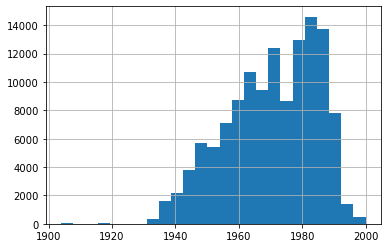

In [333]:
final_df.birth_year.hist(bins=25)

In [334]:
np.std(final_df.birth_year)

14.249990795321649

Previously: 126650

In [337]:
sum(final_df.birth_year.value_counts())

127050

In [338]:
final_df.head()

,Name,gender_wiki,birth_date_wiki,nationality_wiki,gender_dbpedia,birth_date_dbpedia,nationality_dbpedia,gender_gkg,birth_date_gkg,nationality_gkg,video_id,title,publishing_date,description,year_in_title,VoxCeleb_ID,gender,birth_year
0,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,DoazlQs250s,Biathlon: Interview mit Arnd Peiffer (28.01.2013),2013-01-30T12:22:48Z,"""Interview mit Arnd Peiffer beim abschlie\u00d...",2013.0,id00778,male,1987.0
1,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,UKogERawW7I,#Hochfilzen2017: Gold for Germany in Mixed Relay,2017-02-09T17:21:31Z,"""It was a successful first competition for the...",2017.0,id00778,male,1987.0
2,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,gpK4kMSrU2U,"Östersund-2016. Comments from Benedikt Doll, A...",2016-11-28T07:05:06Z,"""\u00d6stersund-2016. Comments from Benedikt D...",2016.0,id00778,male,1987.0
3,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,QuQSwM6Hhtg,Biathlon: Interview mit Arnd Peiffer (30.10.2012),2012-11-02T07:53:38Z,"""Interview mit Arnd Peiffer bei der DSV-Einkle...",2012.0,id00778,male,1987.0
4,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,JHx3ulJfMtA,Arnd Peiffer,2010-03-15T02:32:14Z,"""Interview nach dem Verfolgungsrennen in Konti...",NaN,id00778,male,1987.0


In [339]:
final_df.to_csv("../dataset/final_dataframe_gender_birth_year.csv", index=False)

# Speaker age
For a good ammount of speakers we were able to infer their birth year. To get an estimate related to age we need to know the year of recorging of a given video

In [340]:
final_df = pd.read_csv('../dataset/final_dataframe_gender_birth_year.csv')

In [341]:
final_df.head()

,Name,gender_wiki,birth_date_wiki,nationality_wiki,gender_dbpedia,birth_date_dbpedia,nationality_dbpedia,gender_gkg,birth_date_gkg,nationality_gkg,video_id,title,publishing_date,description,year_in_title,VoxCeleb_ID,gender,birth_year
0,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,DoazlQs250s,Biathlon: Interview mit Arnd Peiffer (28.01.2013),2013-01-30T12:22:48Z,"""Interview mit Arnd Peiffer beim abschlie\u00d...",2013.0,id00778,male,1987.0
1,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,UKogERawW7I,#Hochfilzen2017: Gold for Germany in Mixed Relay,2017-02-09T17:21:31Z,"""It was a successful first competition for the...",2017.0,id00778,male,1987.0
2,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,gpK4kMSrU2U,"Östersund-2016. Comments from Benedikt Doll, A...",2016-11-28T07:05:06Z,"""\u00d6stersund-2016. Comments from Benedikt D...",2016.0,id00778,male,1987.0
3,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,QuQSwM6Hhtg,Biathlon: Interview mit Arnd Peiffer (30.10.2012),2012-11-02T07:53:38Z,"""Interview mit Arnd Peiffer bei der DSV-Einkle...",2012.0,id00778,male,1987.0
4,Arnd Peiffer,male,1987-03-18,Germany,male,1987-3-18,NaN,male,1987-03-18,Germany,JHx3ulJfMtA,Arnd Peiffer,2010-03-15T02:32:14Z,"""Interview nach dem Verfolgungsrennen in Konti...",NaN,id00778,male,1987.0


Let's get the year of upload of the video in YT:

In [342]:
final_df.publishing_date

0         2013-01-30T12:22:48Z
1         2017-02-09T17:21:31Z
2         2016-11-28T07:05:06Z
3         2012-11-02T07:53:38Z
4         2010-03-15T02:32:14Z
                  ...         
149345    2013-03-04T14:07:36Z
149346    2015-08-06T08:09:00Z
149347    2015-08-01T08:20:09Z
149348                     NaN
149349    2013-03-19T08:56:16Z
Name: publishing_date, Length: 149350, dtype: object

In [343]:
year_upload = final_df.publishing_date.astype(str)
year_upload = [x[0:4] for x in year_upload]
year_upload[0:10]

['2013',
 '2017',
 '2016',
 '2012',
 '2010',
 '2013',
 '2013',
 '2017',
 '2015',
 '2013']

Now we can have a look at how many records have a reference of the upload year in Title, Description or both:

In [344]:
matching_year_title = 0
matching_year_desc = 0
matching_title_desc = 0
for i in range(0, final_df.shape[0]):
    current_record = final_df.iloc[i:]
    if len(year_upload[i]) >= 4:
        if year_upload[i] in current_record.description.values[0] and year_upload[i] in current_record.title.values[0]:
            matching_title_desc += 1
        elif year_upload[i] in current_record.title.values[0]:
            matching_year_title += 1
        elif year_upload[i] in current_record.description.values[0]:
            matching_year_desc += 1
                

In [345]:
matching_year_title

8834

In [346]:
matching_year_desc

14273

In [347]:
matching_title_desc

7642

In [348]:
final_df.shape

(149350, 18)

Let's now check the contracted form of the year (e.g. 2017 -> '17)

In [351]:
matching_year_title_contracted = 0
matching_year_desc_contracted = 0
for i in range(0, final_df.shape[0]):
    current_record = final_df.iloc[i:]
    if len(year_upload[i]) >= 4:
        contracted_year = "'{}".format(year_upload[i][2:4])
        # Just to see some examples
        if i % 40000 == 0:
            print(contracted_year)
        if contracted_year in current_record.title.values[0]:
            matching_year_title += 1
        if contracted_year in current_record.description.values[0]:
            matching_year_desc += 1

'13
'13
'10
'13


In [352]:
matching_year_title_contracted

0

In [353]:
matching_year_desc_contracted

0

Let's now add this information to our dataset:

In [357]:
final_df['year_upload_yt'] = year_upload

In [358]:
def recording_year_fun(row):
    if type(row['year_upload_yt']) == type(row['title']) ==  type(row['description']) == str:
        if len(row['year_upload_yt']) >= 4 and row['year_upload_yt'] in row['title'] and row['year_upload_yt'] in row['description']:
            return row['year_upload_yt']
    else:
        return np.nan

In [359]:
%%time
final_df['recording_year'] = final_df.apply(lambda row: recording_year_fun(row), axis=1)

Wall time: 3.89 s


In [360]:
final_df.recording_year.value_counts()

2016    1293
2013    1130
2015    1039
2014    1037
2012     893
2011     646
2017     552
2010     500
2009     292
2008     192
2007      57
2006      11
Name: recording_year, dtype: int64

In [361]:
sum(final_df.recording_year.value_counts())

7642

Let's store in another variable the recording year computed only by checking the YT video title:

In [362]:
def recording_year_fun_title_only(row):
    if type(row['year_upload_yt']) == type(row['title']) ==  type(row['description']) == str:
        if len(row['year_upload_yt']) >= 4 and row['year_upload_yt'] in row['title']:
            return row['year_upload_yt']
    else:
        return np.nan

In [363]:
%%time
final_df['recording_year_title_only'] = final_df.apply(lambda row: recording_year_fun_title_only(row), axis=1)

Wall time: 3.21 s


In [364]:
final_df['recording_year'] = pd.to_numeric(final_df['recording_year'], errors='coerce')
final_df['recording_year_title_only'] = pd.to_numeric(final_df['recording_year_title_only'], errors='coerce')

Now we can compute the speaker age as a simple difference between the year of the recording and the birth year of the given person:

In [365]:
final_df['speaker_age'] = final_df['recording_year'] - final_df['birth_year']
final_df['speaker_age_title_only'] = final_df['recording_year_title_only'] - final_df['birth_year']

Let's now compute some statistics:

In [366]:
final_df['speaker_age'].value_counts()

31.0    249
32.0    237
27.0    236
30.0    225
29.0    215
       ... 
85.0      1
92.0      1
83.0      1
10.0      1
11.0      1
Name: speaker_age, Length: 77, dtype: int64

In [367]:
final_df['speaker_age_title_only'].value_counts()

31.0    532
27.0    498
32.0    482
28.0    464
29.0    460
       ... 
11.0      1
94.0      1
83.0      1
95.0      1
85.0      1
Name: speaker_age_title_only, Length: 79, dtype: int64

Prev: 6582

In [368]:
sum(final_df.speaker_age.value_counts())

6601

In [369]:
sum(final_df['speaker_age_title_only'].value_counts())

14247

# TO DO for additional data:
For 1K+ records only the recording year was present. Let's find out which are the problematic rows:

In [281]:
without_birth_year_records = final_df.loc[(final_df.recording_year > 0) & (final_df.birth_year.isna()),['Name', 'birth_date_wiki', 'birth_date_dbpedia', 'birth_date_gkg']]

In [282]:
without_birth_year_records = without_birth_year_records.drop_duplicates()

We can split these records in the following categories:
- Speakers with 3 NAs => Understand why it happened
- Speakers with 1 NA => Ignore the missing value, keep the others
- Speakers without NA => For the moment let's  not do anything

In [283]:
not_na_count = without_birth_year_records.count(axis=1)
one_na_df = without_birth_year_records.loc[not_na_count==3,:]

In [284]:
one_na_df

,Name,birth_date_wiki,birth_date_dbpedia,birth_date_gkg
234,Bettina Zimmermann,1975-03-31,NaN,1975-03-31
1671,Aco Petrović,1959-10-14,1959-10-14,NaN
2944,Anderson Cooper,1967-06-03,1967-06-03,NaN
3131,Perry Farrell,1959-03-29,1959-03-29,NaN
3256,Cole Sprouse,1992-08-04,NaN,1992-08-04
...,...,...,...,...
146772,Charlotte Salt,1985-08-12,NaN,1985-08-12
147216,Monifah,1971-01-28,1972-01-28,NaN
147585,Phil Kessel,1987-10-02,NaN,1987-10-02
147903,Jasmin Tabatabai,1967-06-08,1967-6-8,NaN


In [287]:
one_na_df['birth_year'] = one_na_df.apply(lambda row: birth_fun(row, True), axis=1)

C:\Users\hechm\miniconda3\envs\enrich_yt_videos\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Speaker age on whole dataset'}, ylabel='Frequency'>

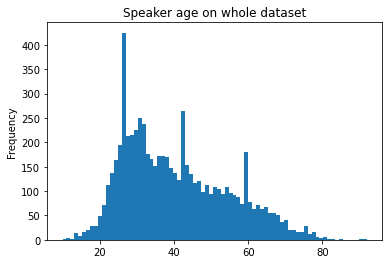

In [288]:
final_df['speaker_age'].plot(kind='hist',bins=77, title="Speaker age on whole dataset")

# Store final df:

In [375]:
final_df.to_csv("../dataset/final_dataframe_extended.csv", index=False)